# Análisis Exploratorio Inicial: tabla fact order items
# Dataset: Brazilian E-Commerce Public Dataset by Olist
[https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce]

Yasmin Ohana - legajo: 65098

Julia Sexe - legajo: 65669

Alexis Florian Rehmann - legajo: 61251

##Carga de librerías necesarias y gestión de warnings.

In [1]:
import os, json, pathlib
import zipfile, pathlib, re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox, zscore
from scipy.special import inv_boxcox
from scipy.stats import yeojohnson
from scipy.stats import chi2
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# === Celda única para gestionar warnings / ruidos numéricos ===

from statsmodels.tools.sm_exceptions import (
    ConvergenceWarning, PerfectSeparationWarning,
    HessianInversionWarning, IterationLimitWarning
)

# 0) Mostrar cualquier warning no filtrado solo una vez
warnings.filterwarnings("once")

# 1) Deprecations generales
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1.a) Deprecation específico que te aparece (jupyter_client: datetime.utcnow)
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module=r"jupyter_client\..*",
    message=r".*datetime\.utcnow\(\) is deprecated.*"
)

# 2) Warnings clásicos de statsmodels en Logit
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=HessianInversionWarning)
warnings.filterwarnings("ignore", category=IterationLimitWarning)
warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module=r"statsmodels\..*")

# 3) RuntimeWarning numéricos dentro de statsmodels (los de tu screenshot)
warnings.filterwarnings("ignore", category=RuntimeWarning, module=r"statsmodels\..*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=r".*overflow encountered in exp.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=r".*divide by zero encountered.*")

# 4) (Opcional) silenciar avisos de overflow/divide de NumPy en todo el notebook
np.seterr(over='ignore', divide='ignore', invalid='ignore', under='ignore')

# por categoría + módulo
warnings.filterwarnings("ignore",
    category=PendingDeprecationWarning,
    module=r"seaborn\..*")

##Ingesta de los datos desde Kaggle.
Aclaración: los archivos crudos están subidos en el repositorio de GitHub pero no realizamos la ingesta desde ahí ya que el archivo "Olist_geolocation_dataset.csv" era muy pesado y no permitía ser subido al repositorio.

In [3]:
!pip -q install kaggle

KAGGLE_USERNAME = "yasminohana1"
KAGGLE_KEY      = "4b30102e8deedd1447edf89efab04761"

os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

path = pathlib.Path("~/.kaggle").expanduser()
path.mkdir(parents=True, exist_ok=True)
with open(path / "kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
def kaggle_slug_from_url(url_or_slug: str) -> str:
    m = re.search(r"kaggle\.com/datasets/([^/?#]+/[^/?#]+)", url_or_slug)
    return m.group(1) if m else url_or_slug.strip()

def kaggle_download(url_or_slug: str, dest="/content/data"):
    slug = kaggle_slug_from_url(url_or_slug)
    dest = pathlib.Path(dest)
    dest.mkdir(parents=True, exist_ok=True)
    print(f"Descargando: {slug} → {dest}")
    !kaggle datasets download -d {slug} -p {dest} -q
    # descomprimir todos los .zip que queden en dest
    for z in dest.glob("*.zip"):
        with zipfile.ZipFile(z) as zf:
            zf.extractall(dest)
        z.unlink()
    print("Listo. Archivos en:", dest)
    return dest

In [5]:
olist_dir = kaggle_download("https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce",
                            dest="/content/olist")
!ls -1 {olist_dir}

Descargando: olistbr/brazilian-ecommerce → /content/olist
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
Listo. Archivos en: /content/olist
olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_order_items_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_orders_dataset.csv
olist_products_dataset.csv
olist_sellers_dataset.csv
product_category_name_translation.csv


In [6]:
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

DATA = Path("/content/olist")

date_cols_orders = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date",
    "order_estimated_delivery_date"
]

orders   = pd.read_csv(DATA/"olist_orders_dataset.csv", parse_dates=date_cols_orders)
items    = pd.read_csv(DATA/"olist_order_items_dataset.csv", parse_dates=["shipping_limit_date"])
payments = pd.read_csv(DATA/"olist_order_payments_dataset.csv")
reviews  = pd.read_csv(DATA/"olist_order_reviews_dataset.csv",
                       parse_dates=["review_creation_date","review_answer_timestamp"])
customers= pd.read_csv(DATA/"olist_customers_dataset.csv")
sellers  = pd.read_csv(DATA/"olist_sellers_dataset.csv")
products = pd.read_csv(DATA/"olist_products_dataset.csv")
geo      = pd.read_csv(DATA/"olist_geolocation_dataset.csv")
cats_tr  = pd.read_csv(DATA/"product_category_name_translation.csv")

##Análisis exploratorio inicial de los datos.

###Forma y tamaño del dataset. Análisis de valores únicos.

In [7]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [8]:
print("geo – filas totales:", f"{len(geo):,}")
pref = geo['geolocation_zip_code_prefix']
print("prefijos únicos:", f"{pref.nunique():,}")
dup = geo.groupby('geolocation_zip_code_prefix').size()
print("% de prefijos con >1 fila:", round((dup > 1).mean()*100, 1), "%")

geo – filas totales: 1,000,163
prefijos únicos: 19,015
% de prefijos con >1 fila: 94.5 %


In [9]:
orders.head()
orders.info()
orders.describe()
for i in orders.columns:
  print(i, orders[i].isnull().sum())

# aca hay nulos, vamos a imputar más adelante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB
order_id 0
customer_id 0
order_status 0
order_purchase_timestamp 0
order_approved_at 160
order_delivered_carrier_date 1783
order_delivered_customer_date 2965
order

In [10]:
orders['order_status'].value_counts()

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


In [11]:
items.head()
items.info()
items.describe()
for i in items.columns:
  print(i, items[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB
order_id 0
order_item_id 0
product_id 0
seller_id 0
shipping_limit_date 0
price 0
freight_value 0


In [12]:
payments.info()
payments.describe()
for i in payments.columns:
  print(i, payments[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
order_id 0
payment_sequential 0
payment_type 0
payment_installments 0
payment_value 0


In [13]:
payments['payment_installments'].value_counts()

,count
payment_installments,
1,52546
2,12413
3,10461
4,7098
10,5328
5,5239
8,4268
6,3920
7,1626


In [14]:
payments['payment_type'].value_counts()

,count
payment_type,
credit_card,76795
boleto,19784
voucher,5775
debit_card,1529
not_defined,3


In [15]:
payments['payment_value'].value_counts()

,count
payment_value,
50.00,324
20.00,274
100.00,255
77.57,250
35.00,165
...,...
19.18,1
713.65,1
366.73,1


In [16]:
payments['payment_sequential'].value_counts()

,count
payment_sequential,
1,99360
2,3039
3,581
4,278
5,170
6,118
7,82
8,54
9,43


In [17]:
reviews.info()
reviews.describe()
for i in reviews.columns:
  print(i, reviews[i].isnull().sum())

# tenemos valores nulos en los titulos y mensajes, pero como son textos decidimos no entrar en el mundo de procesamiento de lenguaje natural.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB
review_id 0
order_id 0
review_score 0
review_comment_title 87656
review_comment_message 58247
review_creation_date 0
review_answer_timestamp 0


In [18]:
reviews['review_score'].value_counts()

,count
review_score,
5,57328
4,19142
1,11424
3,8179
2,3151


In [19]:
reviews['review_answer_timestamp'].nunique()

98248

In [20]:
reviews['review_answer_timestamp'].unique() ##todas fechas

<DatetimeArray>
['2018-01-18 21:46:59', '2018-03-11 03:05:13', '2018-02-18 14:36:24',
 '2017-04-21 22:02:06', '2018-03-02 10:26:53', '2018-04-16 00:39:37',
 '2017-07-18 19:30:34', '2018-08-14 21:36:06', '2017-05-18 12:05:37',
 '2018-05-23 16:45:47',
 ...
 '2018-05-26 21:24:06', '2018-05-20 21:51:06', '2018-05-10 14:37:03',
 '2017-12-14 11:09:36', '2018-04-30 01:18:57', '2018-07-14 17:18:30',
 '2017-12-11 20:06:42', '2018-03-23 09:10:43', '2018-07-02 12:59:13',
 '2017-07-03 21:01:49']
Length: 98248, dtype: datetime64[ns]

In [21]:
customers.info()
customers.describe()
for i in customers.columns:
  print(i, customers[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
customer_id 0
customer_unique_id 0
customer_zip_code_prefix 0
customer_city 0
customer_state 0


In [22]:
customers['customer_unique_id'].value_counts()

,count
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,17
3e43e6105506432c953e165fb2acf44c,9
ca77025e7201e3b30c44b472ff346268,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7
6469f99c1f9dfae7733b25662e7f1782,7
...,...
4f83c83b7ff5b544a8c75dcb8ad66e2e,1
3fe413dde400746c53c5d0d38b266ca2,1
289e1d1ce11a14bb169775d58ad2f1c2,1


In [23]:
customers.shape

(99441, 5)

In [24]:
customers['customer_id'].nunique()

99441

In [25]:
sellers.info()
sellers.describe()
for i in sellers.columns:
  print(i, sellers[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
seller_id 0
seller_zip_code_prefix 0
seller_city 0
seller_state 0


In [26]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [27]:
products.info()
products.describe()
for i in products.columns:
  print(i, products[i].isnull().sum())

# aca hay valores nulos, vamos a imputar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
product_id 0
product_category_name 610
product_name_lenght 610
product_description_lenght 610
product_photos_qty 610
product_weight_g 2
product_length_cm 2
product_height_cm 2
product_width_cm 2


In [28]:
geo.info()
geo.describe()
for i in geo.columns:
  print(i, geo[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
geolocation_zip_code_prefix 0
geolocation_lat 0
geolocation_lng 0
geolocation_city 0
geolocation_state 0


In [29]:
product_categories = products['product_category_name'].dropna().unique()
translated_categories = cats_tr['product_category_name'].unique()
translated_count = sum(category in translated_categories for category in product_categories)

print(f"Out of {len(product_categories)} unique product categories, {translated_count} have translations available.")

Out of 73 unique product categories, 71 have translations available.


In [30]:
cats_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [31]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [32]:
##una orden puede tener varios items, varios pagos y varias reviews. No podemos unir tdoo con todo directo
items_per_order = items.groupby("order_id").size()
pays_per_order  = payments.groupby("order_id").size()
revs_per_order  = reviews.groupby("order_id").size()

print("Items por orden  → mediana:", int(items_per_order.median()), "| máx:", int(items_per_order.max()))
print("Pagos por orden  → mediana:", int(pays_per_order.median()),  "| máx:", int(pays_per_order.max()))
print("Reviews por orden→ mediana:", int(revs_per_order.median()),   "| máx:", int(revs_per_order.max()))

Items por orden  → mediana: 1 | máx: 21
Pagos por orden  → mediana: 1 | máx: 29
Reviews por orden→ mediana: 1 | máx: 3


In [33]:
orders_with_multiple_reviews = revs_per_order[revs_per_order > 1]

if len(orders_with_multiple_reviews) > 0:
    print(f"There are {len(orders_with_multiple_reviews)} orders with more than one review.")
else:
    print("There are no orders with more than one review.")

There are 547 orders with more than one review.


In [34]:
##sumo monto total, tomo la mayor cant de cuotas IGUAL VER, SI ES LA MAYOR O LA SUMA y el metodo mas frecuente
def modo(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

pay_agg = (payments
           .groupby("order_id", as_index=False)
           .agg(payment_value_total=("payment_value","sum"),
                payment_installments_max=("payment_installments","max"),
                payment_type_mode=("payment_type", modo)))

In [35]:
##con las reviews me quedo con la mas reciente

reviews_sorted = reviews.sort_values(["order_id","review_creation_date"])
rev_agg = (reviews_sorted
           .groupby("order_id", as_index=False)
           .agg(review_score=("review_score","last"),
                review_comment_title=("review_comment_title","last"),
                review_comment_message=("review_comment_message","last"),
                review_creation_date=("review_creation_date","last"),
                review_answer_timestamp=("review_answer_timestamp","last")))

In [36]:
geo_agg = (geo.groupby("geolocation_zip_code_prefix", as_index=False)
             .agg(geolocation_lat=("geolocation_lat","mean"),
                  geolocation_lng=("geolocation_lng","mean"),
                  geolocation_city=("geolocation_city", modo),
                  geolocation_state=("geolocation_state", modo)))

In [37]:
##clientes + geo
cust_geo = customers.merge(
    geo_agg.rename(columns={
        "geolocation_zip_code_prefix":"customer_zip_code_prefix",
        "geolocation_lat":"customer_lat","geolocation_lng":"customer_lng",
        "geolocation_city":"customer_geo_city","geolocation_state":"customer_geo_state"
    }),
    on="customer_zip_code_prefix", how="left"
)

In [38]:
##vendedores + geo
sell_geo = sellers.merge(
    geo_agg.rename(columns={
        "geolocation_zip_code_prefix":"seller_zip_code_prefix",
        "geolocation_lat":"seller_lat","geolocation_lng":"seller_lng",
        "geolocation_city":"seller_geo_city","geolocation_state":"seller_geo_state"
    }),
    on="seller_zip_code_prefix", how="left"
)

In [39]:
products_tr = products.merge(cats_tr, on="product_category_name", how="left")

fact_order_items = (items
    .merge(products_tr, on="product_id", how="left")
    .merge(sell_geo,     on="seller_id",  how="left")
    .merge(orders[["order_id","customer_id","order_purchase_timestamp",
                   "order_estimated_delivery_date","order_delivered_customer_date"]],
           on="order_id", how="left")
    .merge(cust_geo[["customer_id","customer_state","customer_city",
                     "customer_zip_code_prefix","customer_lat","customer_lng"]],
           on="customer_id", how="left")
    .merge(pay_agg, on="order_id", how="left")
    .merge(rev_agg, on="order_id", how="left")
)

dups = fact_order_items.duplicated(["order_id","order_item_id"]).sum()
print("fact_order_items:", fact_order_items.shape, "| duplicados clave:", dups)

fact_order_items: (112650, 40) | duplicados clave: 0


In [40]:
print("Shape of original orders dataframe:", orders.shape)
print("Shape of fact_order_items dataframe:", fact_order_items.shape)

Shape of original orders dataframe: (99441, 8)
Shape of fact_order_items dataframe: (112650, 40)


In [41]:
print("Shape of original items dataframe:", items.shape)
print("Shape of fact_order_items dataframe:", fact_order_items.shape)

Shape of original items dataframe: (112650, 7)
Shape of fact_order_items dataframe: (112650, 40)


###Estadísticos principales.

In [42]:
fact_order_items.describe()

,order_item_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_lat,seller_lng,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,customer_zip_code_prefix,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,review_creation_date,review_answer_timestamp
count,112650.000000,112650,112650.000000,112650.000000,111047.000000,111047.000000,111047.000000,112632.000000,112632.000000,112632.000000,112632.000000,112650.000000,112397.000000,112397.000000,112650,112650,110196,112650.000000,112348.000000,112348.000000,112647.000000,112647.000000,111708.000000,111708,111708
mean,1.197834,2018-01-07 15:36:52.192685312,120.653739,19.990320,48.775978,787.867029,2.209713,2093.672047,30.153669,16.593766,22.996546,24439.170431,-22.797711,-47.235518,2018-01-01 00:09:48.464376576,2018-01-24 20:12:15.531291392,2018-01-14 13:25:24.023939328,35119.309090,-21.233540,-46.201855,180.281186,3.018385,4.032701,2018-01-13 17:23:54.160489728,2018-01-16 20:43:15.288896
min,1.000000,2016-09-19 00:15:34,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,-32.079231,-67.813284,2016-09-04 21:15:19,2016-10-04 00:00:00,2016-10-11 13:46:32,1003.000000,-33.689948,-72.668881,9.590000,0.000000,1.000000,2016-10-06 00:00:00,2016-10-07 18:32:28
25%,1.000000,2017-09-20 20:57:27.500000,39.900000,13.080000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,-23.607473,-48.829744,2017-09-13 19:17:04,2017-10-05 00:00:00,2017-09-26 20:09:44.500000,11310.000000,-23.591275,-48.112804,65.670000,1.000000,4.000000,2017-09-26 00:00:00,2017-09-28 21:12:58.249999872
50%,1.000000,2018-01-26 13:59:35,74.990000,16.260000,52.000000,603.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13568.000000,-23.425556,-46.743468,2018-01-19 23:02:16,2018-02-16 00:00:00,2018-02-02 20:57:23,24340.000000,-22.929564,-46.633932,114.440000,2.000000,5.000000,2018-02-03 00:00:00,2018-02-06 01:06:58
75%,1.000000,2018-05-10 14:34:00.750000128,134.900000,21.150000,57.000000,987.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,27930.000000,-21.757321,-46.518679,2018-05-04 17:30:36.750000128,2018-05-28 00:00:00,2018-05-15 20:09:21.500000,59028.750000,-20.171978,-43.635297,195.390000,4.000000,5.000000,2018-05-16 00:00:00,2018-05-20 13:57:42.500000
max,21.000000,2020-04-09 22:35:08,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,-2.501242,-34.855616,2018-09-03 09:06:57,2018-10-25 00:00:00,2018-10-17 13:22:46,99990.000000,42.184003,-8.723762,13664.080000,24.000000,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35
std,0.705124,NaN,183.633928,15.806405,10.025581,652.135608,1.721438,3751.596884,16.153449,13.443483,11.707268,27596.030909,2.697457,2.339961,NaN,NaN,NaN,29866.120801,5.570373,4.037734,272.849042,2.802552,1.387513,NaN,NaN


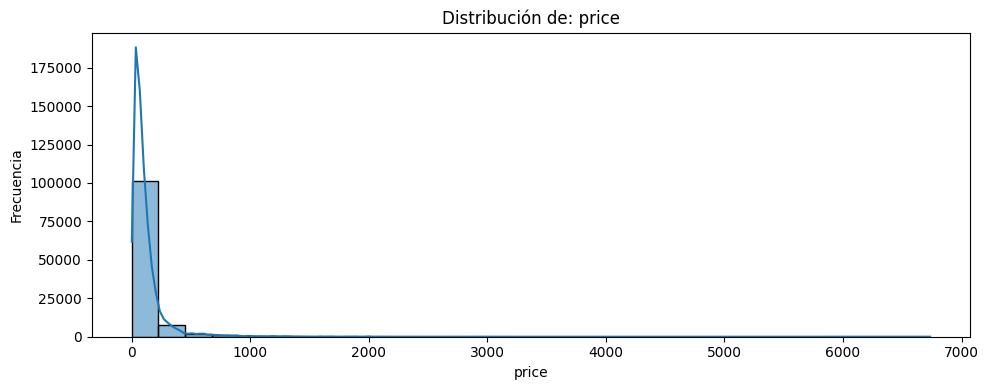

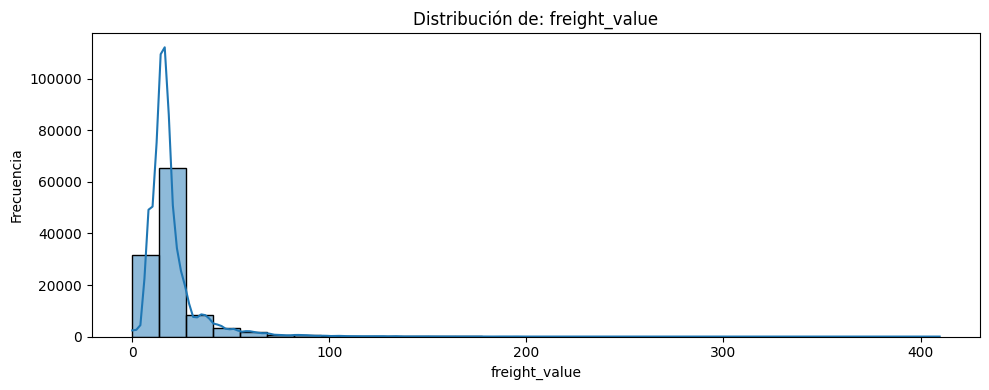

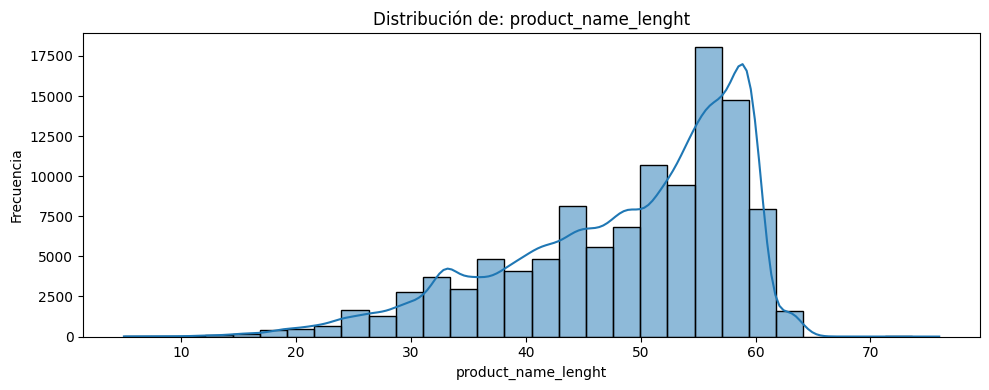

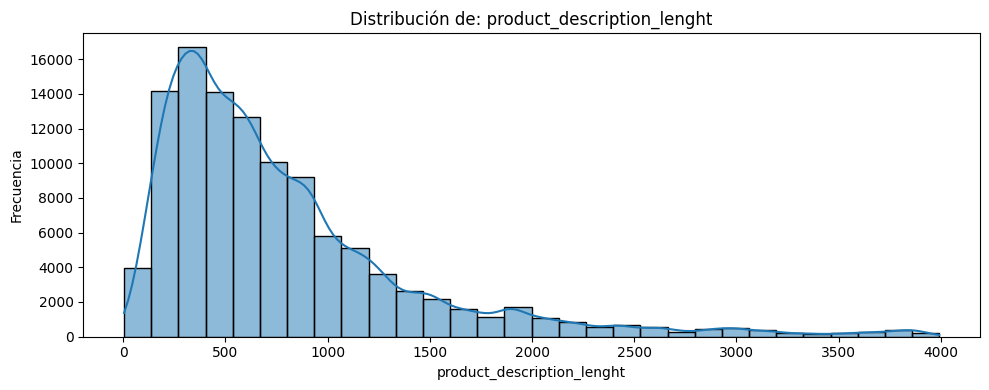

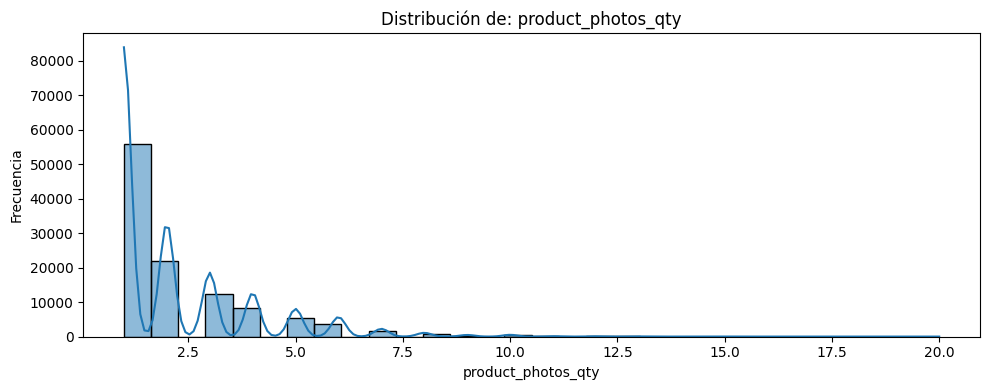

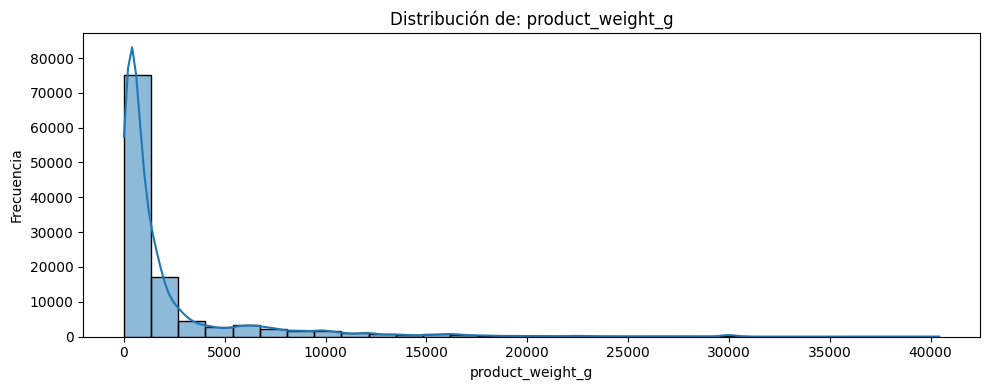

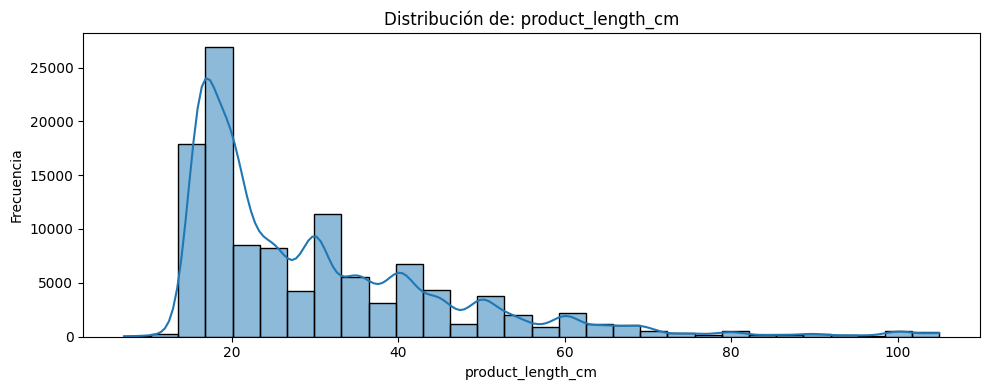

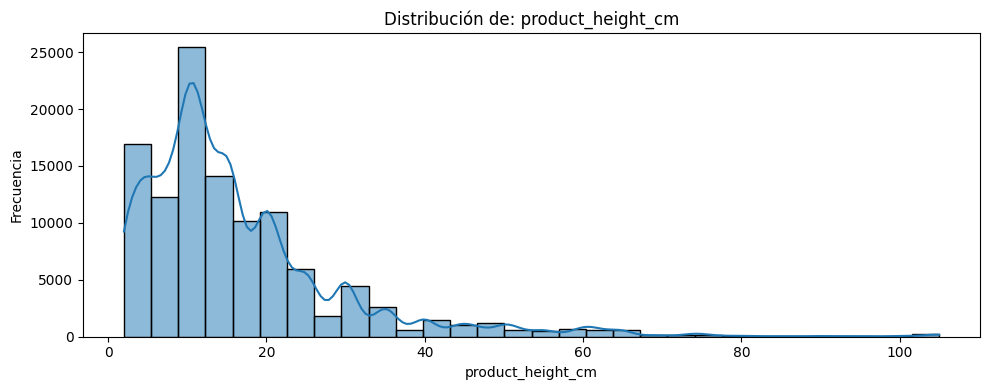

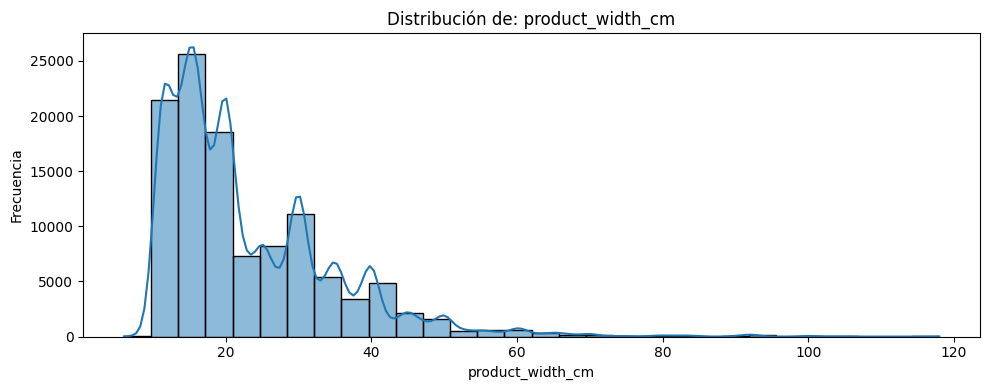

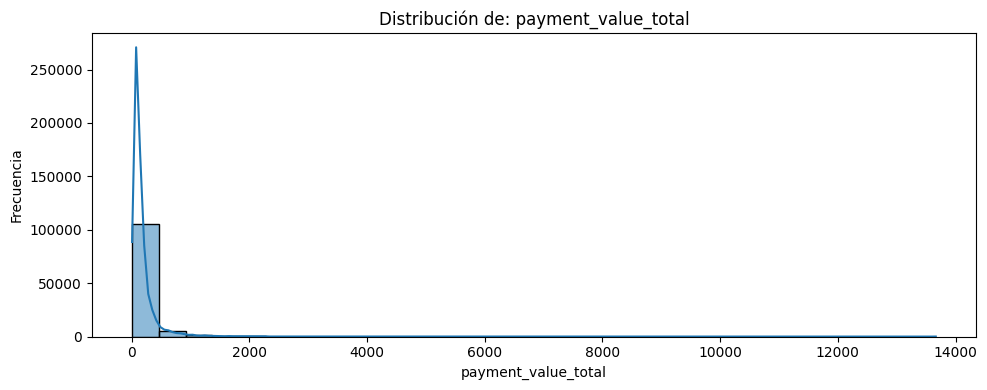

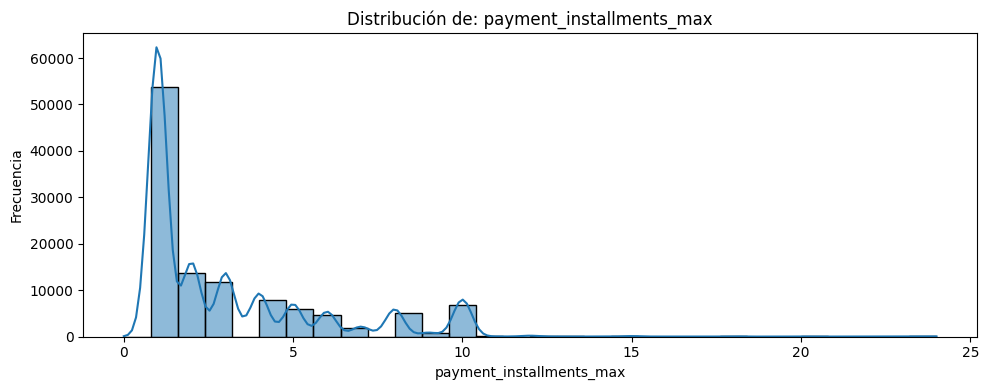

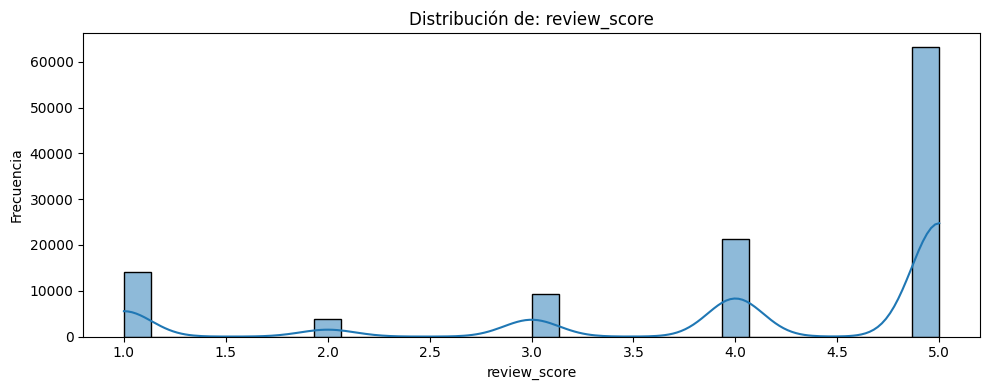

In [43]:
cols_numericas_fact_order_items = fact_order_items.select_dtypes(include=['number']).columns.tolist()

exclude_from_hist_items = [
    'order_id', 'order_item_id', 'product_id', 'seller_id', 'customer_id',
    'customer_zip_code_prefix', 'seller_zip_code_prefix',
    'boxcox_price', 'z_score_price_boxcox', 'z_score_price', 'boxcox_imputed_price', 'cleaned_price',
    'yeojohnson_freight_value', 'z_score_freight_value_yeojohnson', 'z_score_freight_value', 'freight_value_orig',
    'boxcox_product_name_lenght', 'z_score_product_name_lenght_boxcox', 'z_score_product_name_lenght', 'boxcox_imputed_product_name_lenght', 'cleaned_product_name_lenght',
    'boxcox_product_description_lenght', 'z_score_product_description_lenght_boxcox', 'z_score_product_description_lenght', 'boxcox_imputed_product_description_lenght', 'cleaned_product_description_lenght',
    'boxcox_product_photos_qty', 'z_score_product_photos_qty_boxcox', 'z_score_product_photos_qty', 'boxcox_imputed_product_photos_qty', 'cleaned_product_photos_qty',
    'yeojohnson_product_weight_g', 'z_score_product_weight_g_yeojohnson', 'z_score_product_weight_g', 'product_weight_g_orig',
    'boxcox_product_length_cm', 'z_score_product_length_cm_boxcox', 'z_score_product_length_cm', 'boxcox_imputed_product_length_cm', 'cleaned_product_length_cm',
    'boxcox_product_height_cm', 'z_score_product_height_cm_boxcox', 'z_score_product_height_cm', 'boxcox_imputed_product_height_cm', 'cleaned_product_height_cm',
    'boxcox_product_width_cm', 'z_score_product_width_cm_boxcox', 'z_score_product_width_cm', 'boxcox_imputed_product_width_cm', 'cleaned_product_width_cm',
    'boxcox_payment_value_total', 'z_score_payment_value_total_boxcox', 'z_score_payment_value_total', 'boxcox_imputed_payment_value_total', 'cleaned_payment_value_total',
    'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson', 'payment_value_total_orig',
    'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng', 'freight_percentage'
]

plot_cols_items = [col for col in cols_numericas_fact_order_items if col not in exclude_from_hist_items and not col.startswith(('boxcox_', 'yeojohnson_', 'z_score_', 'cleaned_', 'delivery_days_'))]

# histograma de variables numericas
for col in plot_cols_items:
    plt.figure(figsize=(10,4))
    sns.histplot(fact_order_items[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de: {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# a simple vista ninguna variable parece tener distribucion normal. abajo hacemos test de hipotesis

Bar charts for discrete numerical variables in fact_order_items:


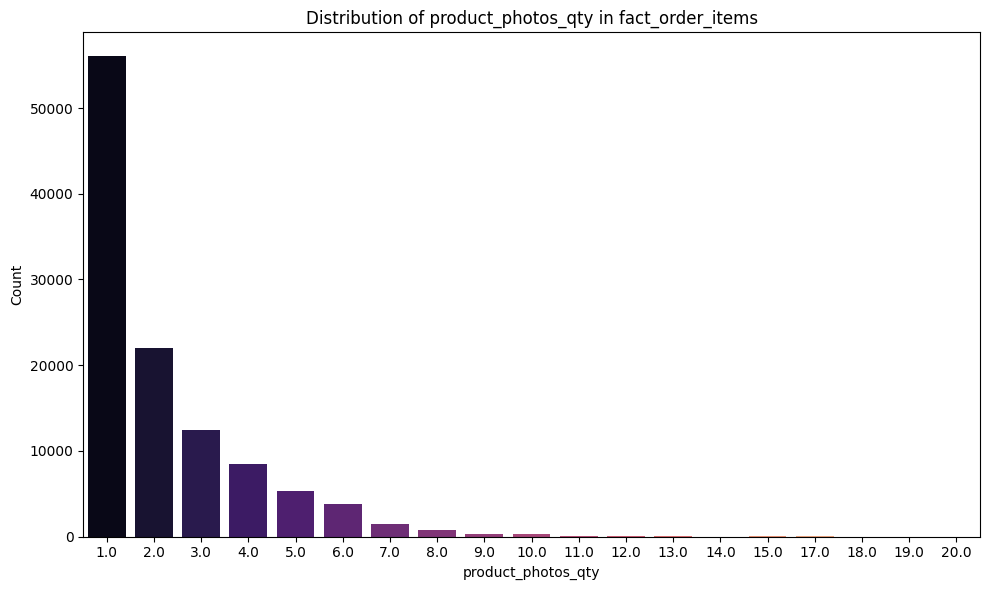

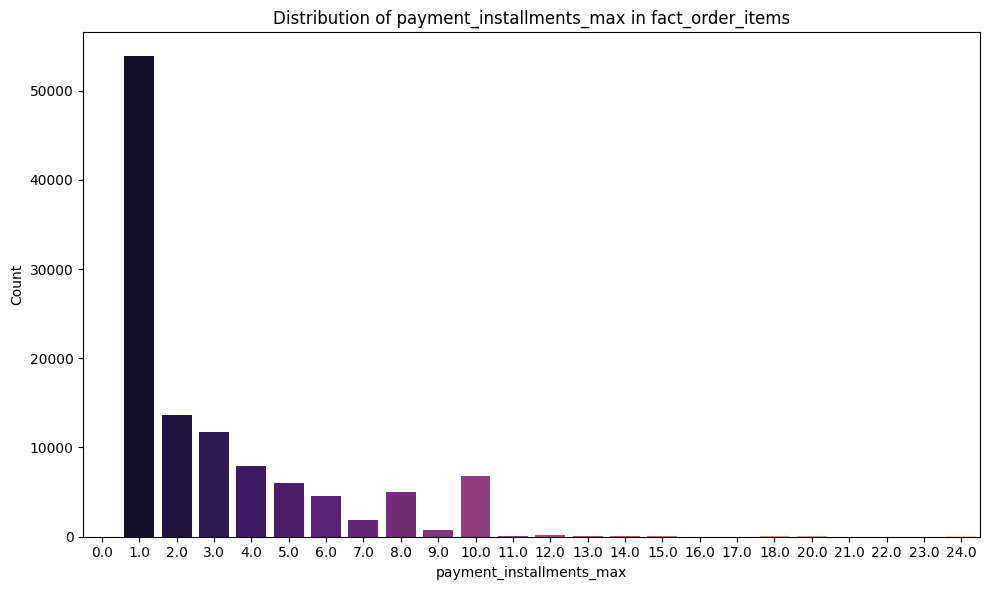

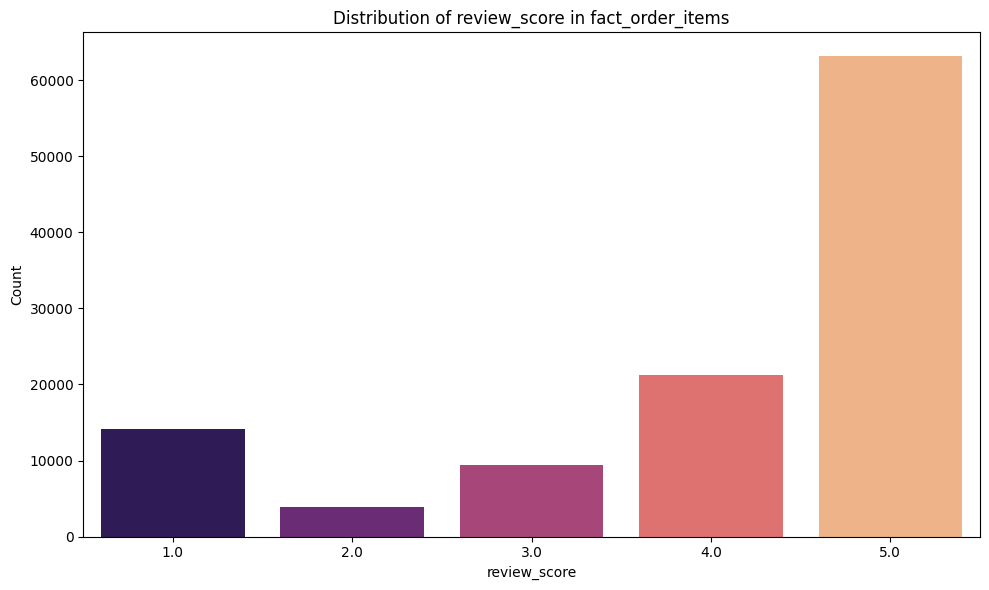

In [44]:
discrete_for_bar_chart_items = ['product_photos_qty', 'payment_installments_max', 'review_score']

print("Bar charts for discrete numerical variables in fact_order_items:")
for col in discrete_for_bar_chart_items:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=fact_order_items.dropna(subset=[col]), x=col, palette='magma')
    plt.title(f'Distribution of {col} in fact_order_items')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

###Análisis de duplicados, nulos y outliers.

In [45]:
print("Checking for duplicates in original dataframes:")
print("Orders duplicates:", orders.duplicated().sum())
print("Items duplicates:", items.duplicated().sum())
print("Payments duplicates:", payments.duplicated().sum())
print("Reviews duplicates:", reviews.duplicated().sum())
print("Customers duplicates:", customers.duplicated().sum())
print("Sellers duplicates:", sellers.duplicated().sum())
print("Products duplicates:", products.duplicated().sum())
print("Geo duplicates:", geo.duplicated().sum())
print("Categories Translation duplicates:", cats_tr.duplicated().sum())

print("\nChecking for duplicates in aggregated dataframes:")
print("Fact Order Items duplicates:", fact_order_items.duplicated().sum())

Checking for duplicates in original dataframes:
Orders duplicates: 0
Items duplicates: 0
Payments duplicates: 0
Reviews duplicates: 0
Customers duplicates: 0
Sellers duplicates: 0
Products duplicates: 0
Geo duplicates: 261831
Categories Translation duplicates: 0

Checking for duplicates in aggregated dataframes:
Fact Order Items duplicates: 0


In [46]:
def top_nulls(df, k=10):
    return (df.isna().mean().mul(100).round(2)
            .sort_values(ascending=False).head(k))

print("\nNulos fact_order_items (top 10):\n", top_nulls(fact_order_items))


Nulos fact_order_items (top 10):
 review_comment_title             88.09
review_comment_message           57.86
order_delivered_customer_date     2.18
product_category_name_english     1.44
product_category_name             1.42
product_description_lenght        1.42
product_name_lenght               1.42
product_photos_qty                1.42
review_answer_timestamp           0.84
review_creation_date              0.84
dtype: float64


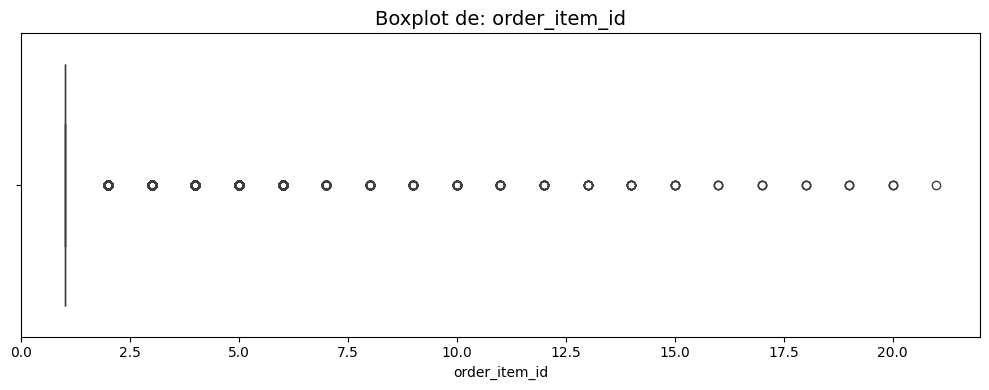

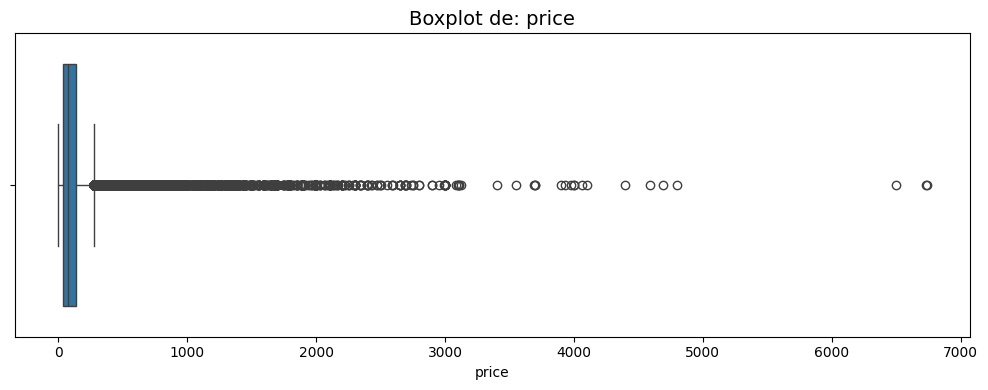

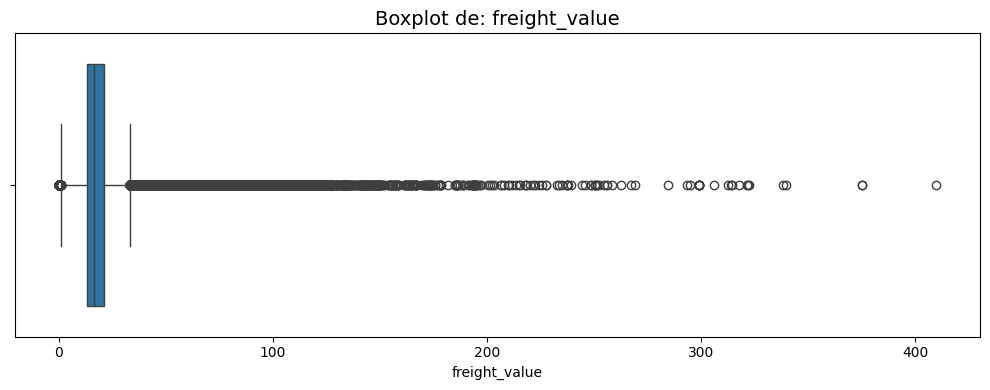

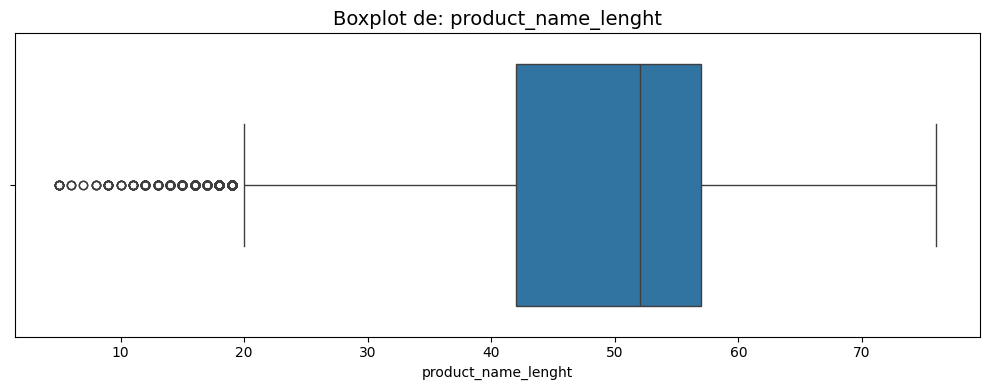

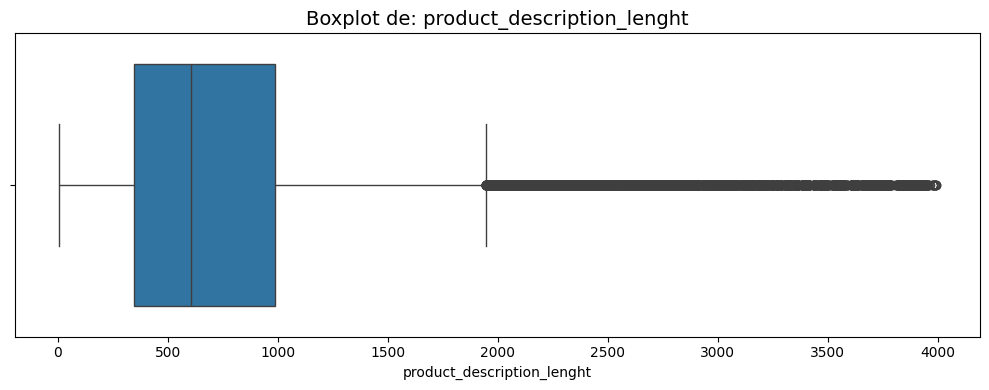

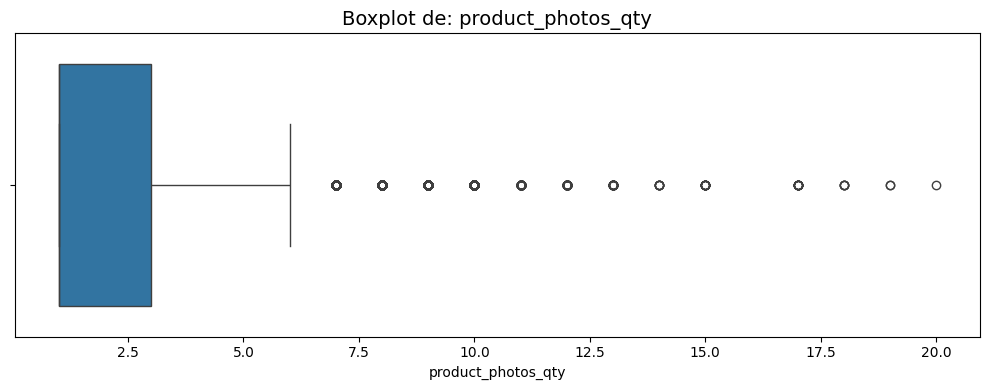

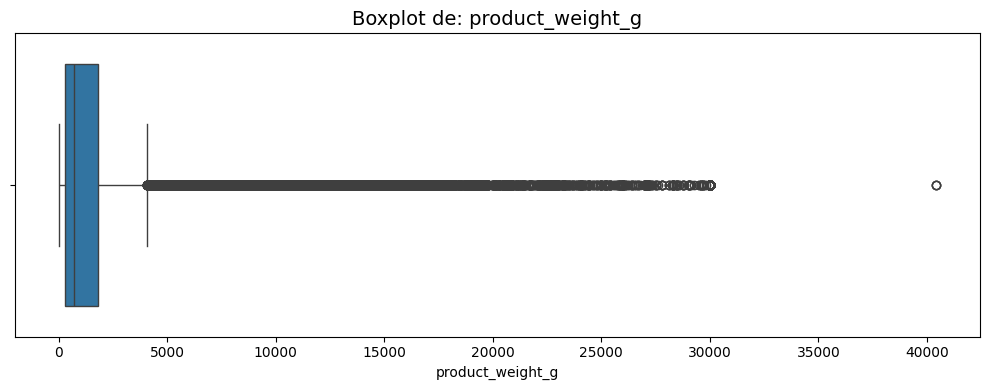

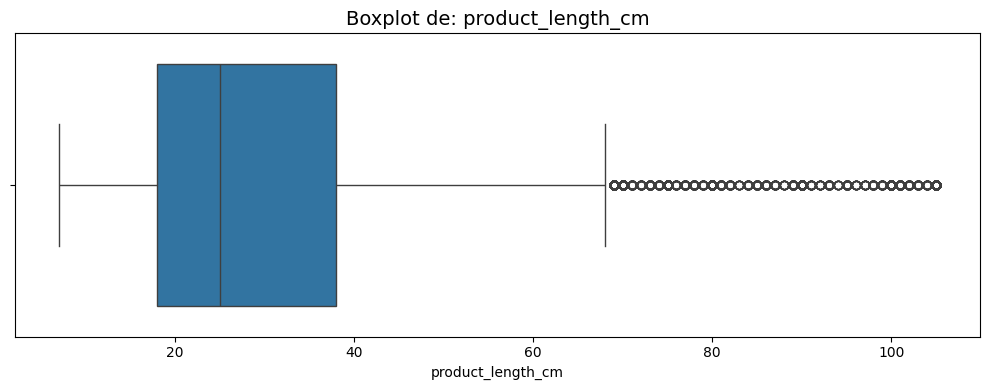

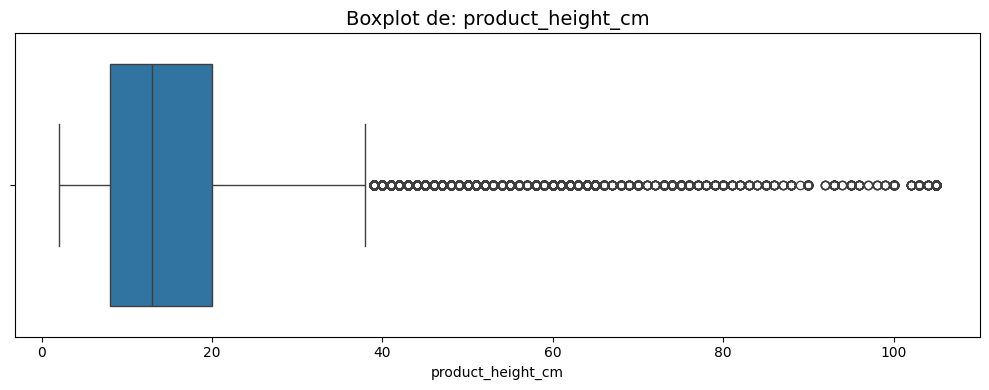

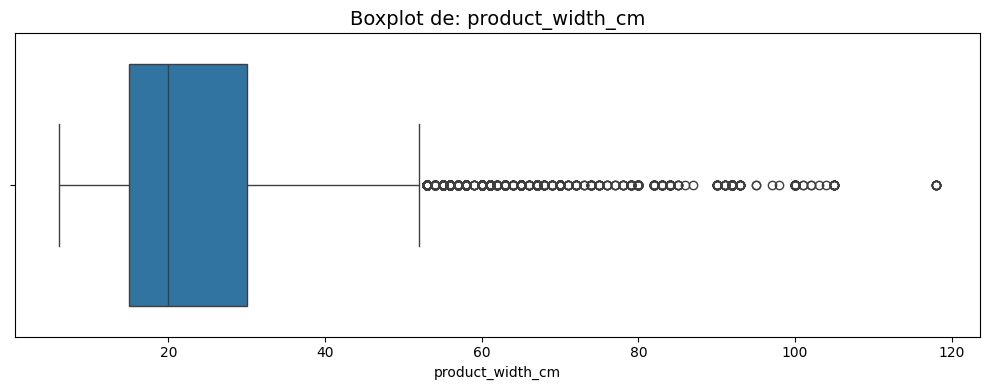

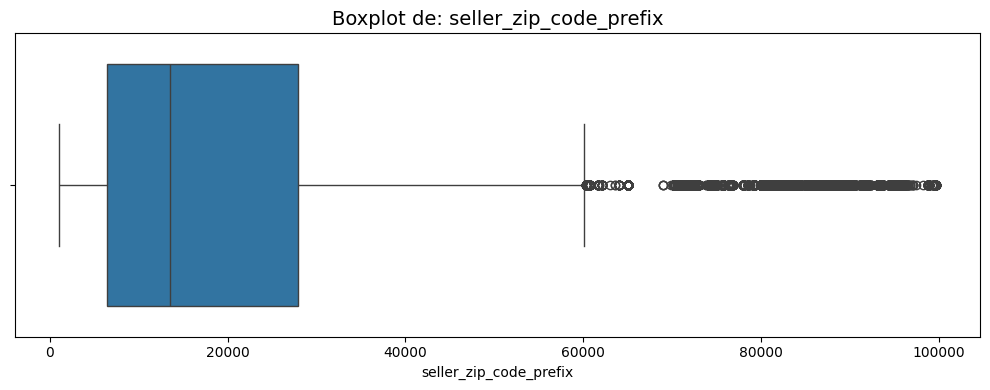

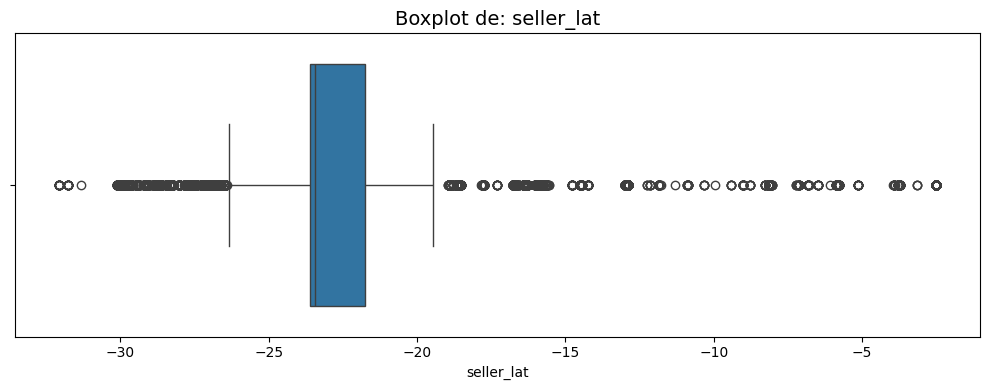

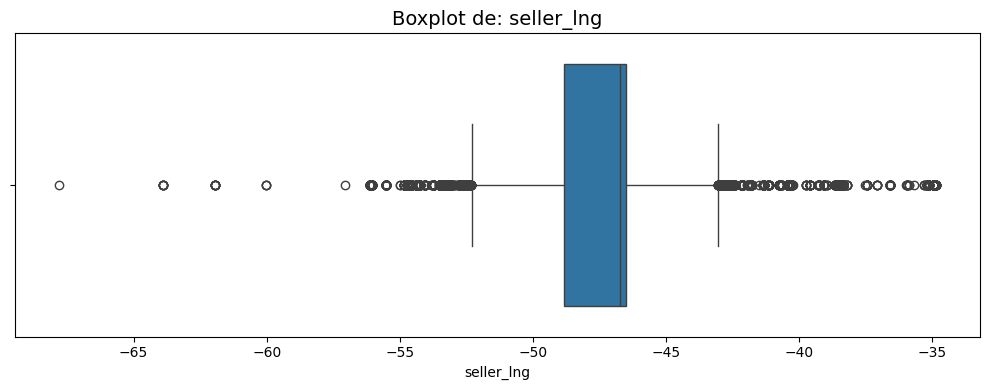

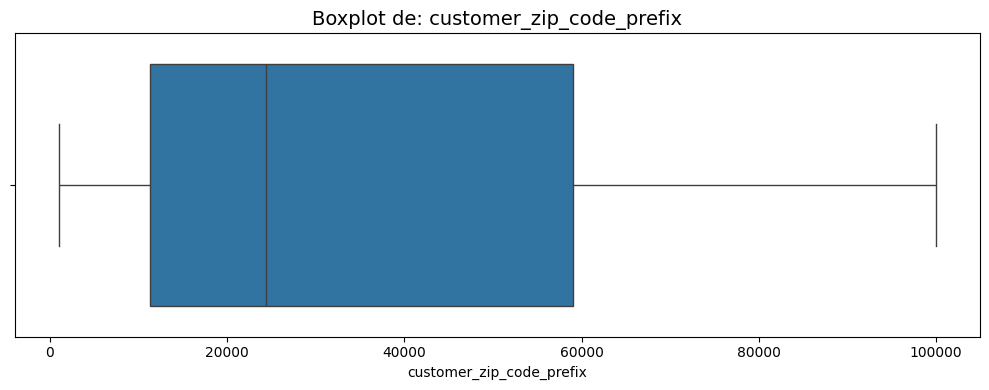

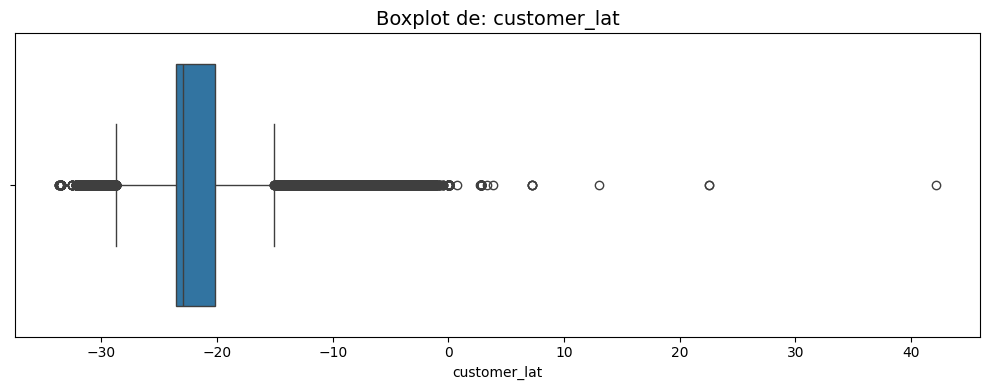

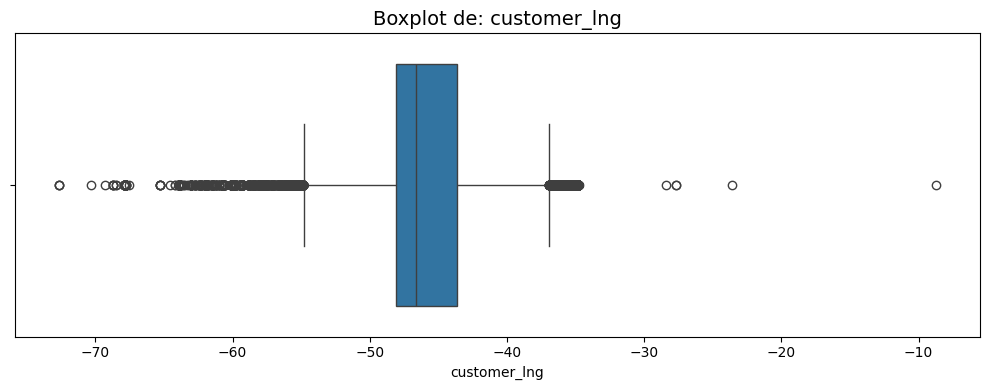

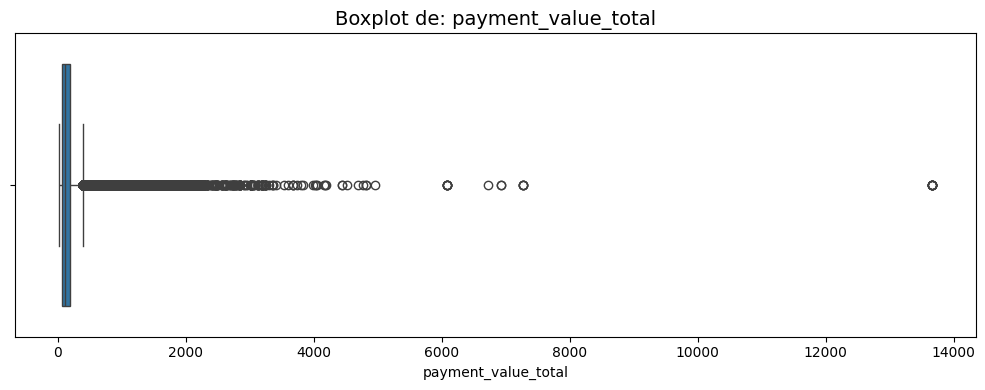

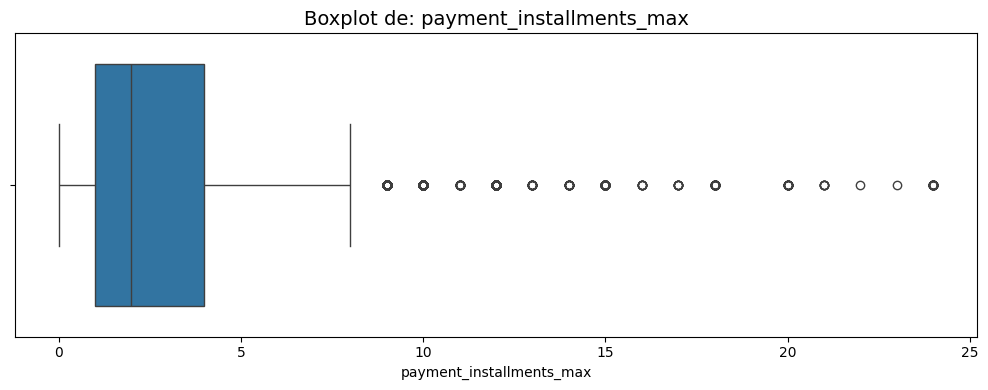

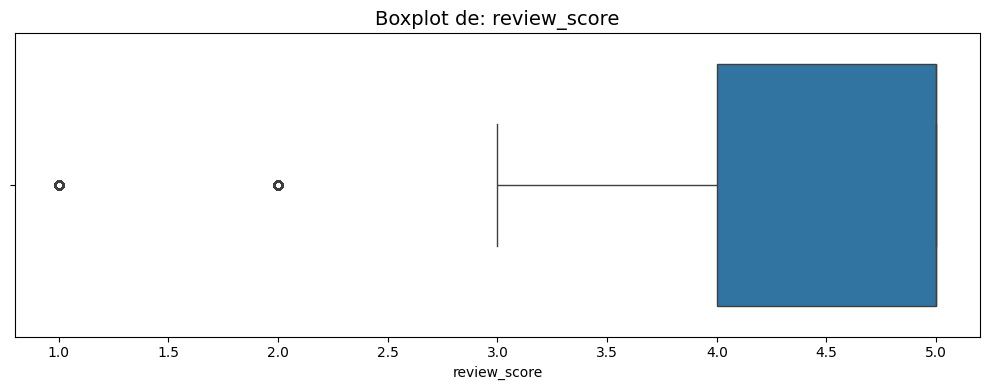

In [47]:
# boxplots para detectar outliers y ver la distribucion de las variables

cols_numericas_fact_order_items = fact_order_items.select_dtypes(include='number').columns

for col in cols_numericas_fact_order_items:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=fact_order_items, x=col)
    plt.title(f"Boxplot de: {col}", fontsize=14)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [48]:
# funcion para detectar outliers usando IQR
def detectar_outliers_iqr(df, columna, severos = False):
    if severos == True:
      sep = 3
    else:
      sep = 1.5
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - sep * IQR
    limite_superior = Q3 + sep * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers.index

qOutliers = 0
qOutliersSeveros = 0
df_outliers_severos = pd.DataFrame()

cols_numericas_fact_order_items_no_geo = [col for col in cols_numericas_fact_order_items if 'lat' not in col and 'lng' not in col]

for col in cols_numericas_fact_order_items_no_geo:
    outliers = detectar_outliers_iqr(fact_order_items, col)
    outliers_severos = detectar_outliers_iqr(fact_order_items, col, severos=True)
    print(f"{col}: {len(outliers)} outliers totales ({len(outliers) / len(fact_order_items) * 100:.2f}%)",
          f" y {len(outliers_severos)} outliers severos ({len(outliers_severos) / len(fact_order_items) * 100:.2f}%)",sep='')
    qOutliers+= len(outliers)
    qOutliersSeveros+= len(outliers_severos)
    outliers_severos = pd.Series(outliers_severos.tolist())
    df_outliers_severos = pd.concat([df_outliers_severos,outliers_severos])

print(f'En total hay {qOutliers} outliers y {qOutliersSeveros} outliers severos')

order_item_id: 13984 outliers totales (12.41%) y 13984 outliers severos (12.41%)
price: 8427 outliers totales (7.48%) y 4074 outliers severos (3.62%)
freight_value: 12134 outliers totales (10.77%) y 5538 outliers severos (4.92%)
product_name_lenght: 772 outliers totales (0.69%) y 0 outliers severos (0.00%)
product_description_lenght: 7011 outliers totales (6.22%) y 2285 outliers severos (2.03%)
product_photos_qty: 3073 outliers totales (2.73%) y 532 outliers severos (0.47%)
product_weight_g: 15807 outliers totales (14.03%) y 11106 outliers severos (9.86%)
product_length_cm: 3617 outliers totales (3.21%) y 988 outliers severos (0.88%)
product_height_cm: 7670 outliers totales (6.81%) y 2723 outliers severos (2.42%)
product_width_cm: 2563 outliers totales (2.28%) y 414 outliers severos (0.37%)
seller_zip_code_prefix: 17384 outliers totales (15.43%) y 1231 outliers severos (1.09%)
customer_zip_code_prefix: 0 outliers totales (0.00%) y 0 outliers severos (0.00%)
payment_value_total: 9200 ou

##Preprocesamiento inicial

###Tratamiento de nulos, duplicados y outliers. Definición de criterios de imputación y justificación.

En el caso de la latitud y longitud, decidimos excluirlos del analisis de outliers porque son direcciones y consideramos que no debiamos incluirlos.

In [49]:
fact_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  object        
 3   seller_id                      112650 non-null  object        
 4   shipping_limit_date            112650 non-null  datetime64[ns]
 5   price                          112650 non-null  float64       
 6   freight_value                  112650 non-null  float64       
 7   product_category_name          111047 non-null  object        
 8   product_name_lenght            111047 non-null  float64       
 9   product_description_lenght     111047 non-null  float64       
 10  product_photos_qty             111047 non-null  float64       
 11  


Analyzing fact_order_items:
Variable: price
Shapiro-Wilk p-Valor: 7.698705813401781e-83
Variable: freight_value
Shapiro-Wilk p-Valor: 3.5240030255072893e-75
Variable: product_name_lenght
Shapiro-Wilk p-Valor: 9.959865423568296e-48
Variable: product_description_lenght
Shapiro-Wilk p-Valor: 3.658990808675758e-61
Variable: product_photos_qty
Shapiro-Wilk p-Valor: 6.196933010587779e-67
Variable: product_weight_g
Shapiro-Wilk p-Valor: 1.0516169342551144e-77
Variable: product_length_cm
Shapiro-Wilk p-Valor: 2.4389832215581008e-60
Variable: product_height_cm
Shapiro-Wilk p-Valor: 2.2773813251694185e-61
Variable: product_width_cm
Shapiro-Wilk p-Valor: 8.923283940166571e-57
Variable: payment_value_total
Shapiro-Wilk p-Valor: 3.933306921559678e-80


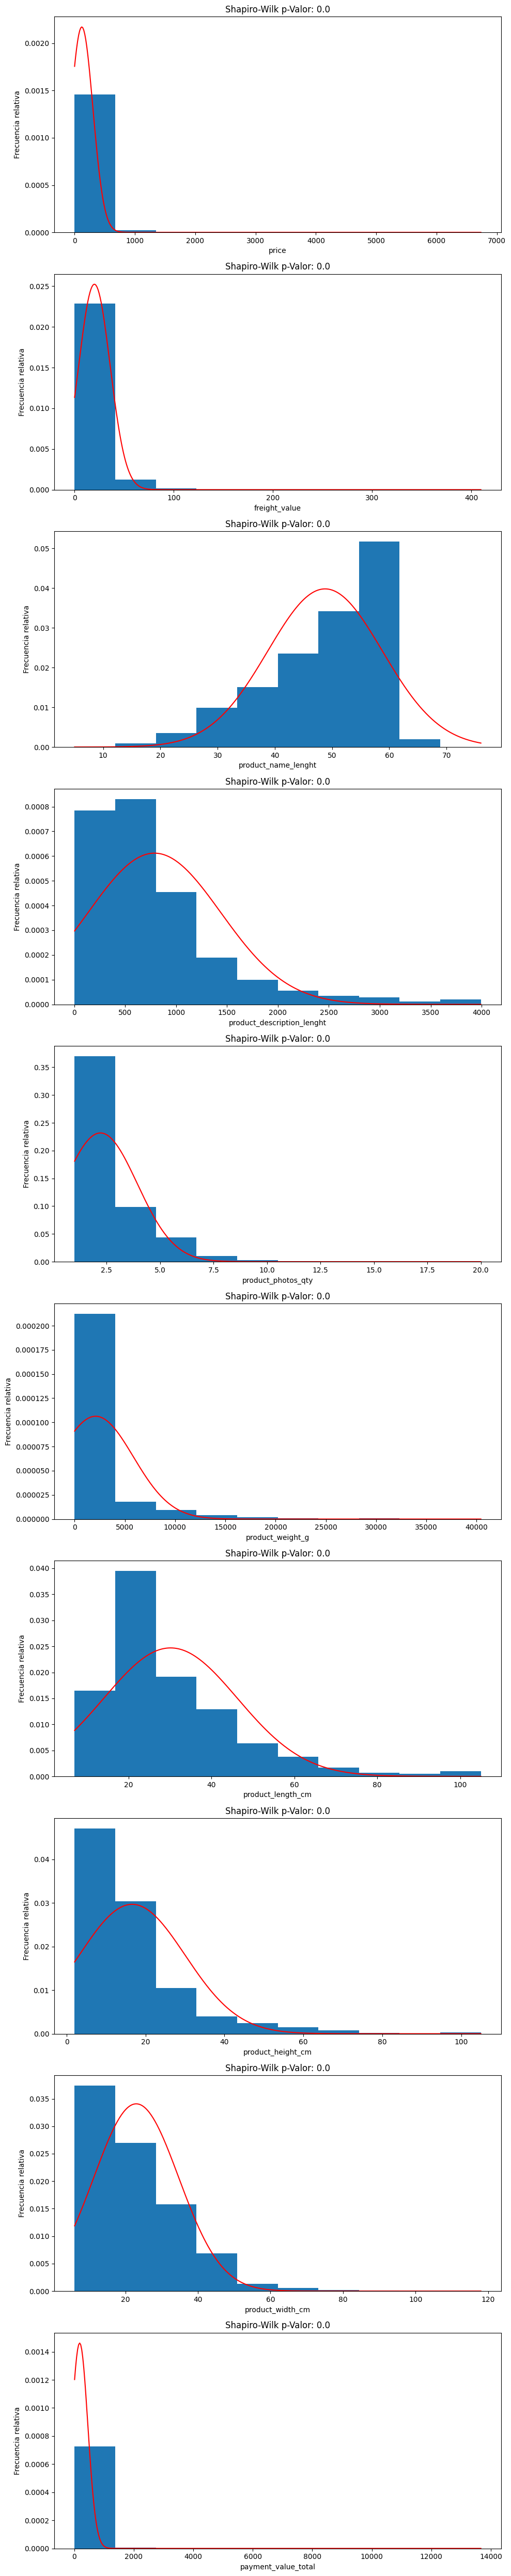

In [50]:
# analizamos los outliers de las variables cuantitativas continuas
# para eso, primero tenemos que ver si son normales

# H0 es que la variable sigue una distribucion normal
# H1 es que no sigue una distribucion normal

# CONTINUAS:
continuous_cols_items = ['price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total']

print("\nAnalyzing fact_order_items:")
fig_items, ax_items = plt.subplots(len(continuous_cols_items), 1, figsize=(10, 5 * len(continuous_cols_items)))

for i, col in enumerate(continuous_cols_items):
  data_filtered = fact_order_items[col].replace([np.inf, -np.inf], np.nan).dropna()

  if len(data_filtered) > 0:
    muVar, sVar = stats.norm.fit(data_filtered)
    mAux = data_filtered.min()
    MAux = data_filtered.max()

    if len(data_filtered) > 5000:
        pvAux = stats.shapiro(data_filtered.sample(5000, random_state=42)).pvalue
    else:
        pvAux = stats.shapiro(data_filtered).pvalue

    print(f"Variable: {col}")
    print(f"Shapiro-Wilk p-Valor: {pvAux}")

    xseq = np.linspace(mAux, MAux, 400)
    yseq = stats.norm(muVar, sVar).pdf(xseq)

    ax_items[i].hist(data_filtered, density=True)
    ax_items[i].plot(xseq, yseq, c="r")
    ax_items[i].set_ylabel("Frecuencia relativa")
    ax_items[i].set_xlabel(col)
    ax_items[i].set_title(f"Shapiro-Wilk p-Valor: {np.round(pvAux, 10)}")
  else:
      print(f"Variable: {col} has no valid data after filtering.")

fig_items.tight_layout()
plt.show()

In [51]:
# analizamos los outliers de las variables cuantitativas continuas
# ahora, como NO son normales, aplicamos boxcox y luego buscamos los outliers con z score y umbral de 4 desviaciones estandar sobre la media

continuous_cols_items = ['price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total']


def aplicar_boxcox_z_score_outliers(df, cols, z_thresh=4.0):  # cols son las columnas que le paso
    for col in cols:
        if col not in df.columns:
            print(f"Column '{col}' not found in the DataFrame. Skipping.")
            continue

        # 1) Transformación Box–Cox (requiere > 0)
        # Filter out non-positive values for Box-Cox
        data_positive = df[col].dropna()
        if (data_positive <= 0).any():
            print(f"Column '{col}' contains non-positive values. Cannot apply Box-Cox directly.")
            # You might consider a different transformation or handle these values
            continue

        sin_na = data_positive
        data_bc, lambda_bc = boxcox(sin_na)

        # Alinear índices
        df[f"boxcox_{col}"] = np.nan
        df.loc[sin_na.index, f"boxcox_{col}"] = data_bc

        # 2) Z-score en Box–Cox
        df[f"z_score_{col}_boxcox"] = zscore(df[f"boxcox_{col}"], nan_policy="omit")
        mask_out_bc = np.abs(df[f"z_score_{col}_boxcox"]) > z_thresh

        # 3) Z-score en escala original (solo para informar)
        df[f"z_score_{col}"] = zscore(df[col], nan_policy="omit")
        mask_out_raw = np.abs(df[f"z_score_{col}"]) > z_thresh

        # 4) Imputación: mediana en espacio Box–Cox (sobre NO-outliers)
        median_bc = np.median(df.loc[~mask_out_bc, f"boxcox_{col}"].dropna()) #dropna() added
        df[f"boxcox_imputed_{col}"] = df[f"boxcox_{col}"].copy()
        df.loc[mask_out_bc, f"boxcox_imputed_{col}"] = median_bc

        # 5) Volver a escala original
        # Ensure lambda_bc is not close to zero before inverse transformation
        if abs(lambda_bc) > 1e-9:
             df[f"cleaned_{col}"] = inv_boxcox(df[f"boxcox_imputed_{col}"], lambda_bc)
        else:
             # Handle the case where lambda is close to zero (log transformation)
             df[f"cleaned_{col}"] = np.exp(df[f"boxcox_imputed_{col}"])


        # 6) Reemplazar en variable original SOLO donde había outliers (según Box–Cox)
        df.loc[mask_out_bc, col] = df.loc[mask_out_bc, f"cleaned_{col}"]

        print(f"Cantidad de outliers en {col} con Box–Cox (|z|>{z_thresh}): {int(mask_out_bc.sum())}")
        print(f"Cantidad de outliers en {col} sin Box–Cox (|z|>{z_thresh}): {int(mask_out_raw.sum())}")
        print("-" * 50)

# Apply to fact_order_items
print("\nApplying Box-Cox and Z-score outlier detection to fact_order_items:")
aplicar_boxcox_z_score_outliers(fact_order_items, continuous_cols_items, z_thresh=4.0)


Applying Box-Cox and Z-score outlier detection to fact_order_items:
Cantidad de outliers en price con Box–Cox (|z|>4.0): 28
Cantidad de outliers en price sin Box–Cox (|z|>4.0): 1205
--------------------------------------------------
Column 'freight_value' contains non-positive values. Cannot apply Box-Cox directly.
Cantidad de outliers en product_name_lenght con Box–Cox (|z|>4.0): 1
Cantidad de outliers en product_name_lenght sin Box–Cox (|z|>4.0): 18
--------------------------------------------------
Cantidad de outliers en product_description_lenght con Box–Cox (|z|>4.0): 9
Cantidad de outliers en product_description_lenght sin Box–Cox (|z|>4.0): 1109
--------------------------------------------------
Cantidad de outliers en product_photos_qty con Box–Cox (|z|>4.0): 0
Cantidad de outliers en product_photos_qty sin Box–Cox (|z|>4.0): 532
--------------------------------------------------
Column 'product_weight_g' contains non-positive values. Cannot apply Box-Cox directly.
Cantidad d

Podemos ver que hay algunas variables que tienen valores negativos, por lo tanto aplicaremos Yeo Johnson en vez de Box Cox.

In [52]:
# ahora usamos yeo johnson

continuous_cols_items_yeo = ['freight_value', 'product_weight_g', 'payment_value_total']

def aplicar_yeojohnson_z_score_outliers(df, cols, z_thresh=4.0):  # cols son las columnas que le paso
    for col in cols:
        if col not in df.columns:
            print(f"Column '{col}' not found in the DataFrame. Skipping.")
            continue

        # Transformación Yeo–Johnson (admite <= 0)
        sin_na = pd.to_numeric(df[col], errors="coerce").dropna()
        if len(sin_na) == 0:
            print(f"Column '{col}' has no valid data after dropping NaNs. Skipping.")
            continue

        data_yj, lambda_yj = yeojohnson(sin_na)

        # Alinear índices para guardar resultados
        df[f"yeojohnson_{col}"] = np.nan
        df.loc[sin_na.index, f"yeojohnson_{col}"] = data_yj

        # Z-score en Yeo–Johnson
        df[f"z_score_{col}_yeojohnson"] = zscore(df[f"yeojohnson_{col}"], nan_policy="omit")
        mask_out_yj = np.abs(df[f"z_score_{col}_yeojohnson"]) > z_thresh

        # Z-score en escala original (solo para informar)
        df[f"z_score_{col}"] = zscore(df[col], nan_policy="omit")
        mask_out_raw = np.abs(df[f"z_score_{col}"]) > z_thresh

        # Mediana en escala original usando NO-outliers (según YJ)
        med_orig = df.loc[~mask_out_yj, col].median()
        # Respaldo
        df[f"{col}_orig"] = df[col].copy()
        # Si la columna es entera, mantener tipo
        med_use = int(round(med_orig)) if pd.api.types.is_integer_dtype(df[col].dtype) else med_orig
        # Reemplazo en la variable ORIGINAL solo donde hay outliers (según YJ)
        df.loc[mask_out_yj, col] = med_use

        print(f"Cantidad de outliers en {col} con Yeo–Johnson (|z|>{z_thresh}): {int(mask_out_yj.sum())}")
        print(f"Cantidad de outliers en {col} sin transformación (|z|>{z_thresh}): {int(mask_out_raw.sum())}")
        print("-" * 50)

print("\nApplying Yeo-Johnson and Z-score outlier detection to fact_order_items:")
aplicar_yeojohnson_z_score_outliers(fact_order_items, continuous_cols_items_yeo, z_thresh=4.0)


Applying Yeo-Johnson and Z-score outlier detection to fact_order_items:
Cantidad de outliers en freight_value con Yeo–Johnson (|z|>4.0): 750
Cantidad de outliers en freight_value sin transformación (|z|>4.0): 1192
--------------------------------------------------
Cantidad de outliers en product_weight_g con Yeo–Johnson (|z|>4.0): 13
Cantidad de outliers en product_weight_g sin transformación (|z|>4.0): 1422
--------------------------------------------------
Cantidad de outliers en payment_value_total con Yeo–Johnson (|z|>4.0): 0
Cantidad de outliers en payment_value_total sin transformación (|z|>4.0): 1054
--------------------------------------------------


Aplicamos BoxCox y Yeo Johnson. Ahora vamos a imputar los outliers detectados.

In [53]:
def chequear_outliers_post(df, cols_boxcox, cols_yeo, z_thresh=4.0):

    for col in cols_boxcox + cols_yeo:
        # b) Escala original (ya reemplazada)
        z_raw = zscore(pd.to_numeric(df[col], errors="coerce"), nan_policy="omit")
        rem_raw = int(np.nansum(np.abs(z_raw) > z_thresh))

        # a) Box–Cox imputado (si existe la columna)
        rem_bc = None
        bc_col = f"boxcox_imputed_{col}"
        if bc_col in df.columns:
            z_bc_imp = zscore(pd.to_numeric(df[bc_col], errors="coerce"), nan_policy="omit")
            rem_bc = int(np.nansum(np.abs(z_bc_imp) > z_thresh))

        # c) Yeo–Johnson (recalcular sobre la columna actual para chequear)
        x = pd.to_numeric(df[col], errors="coerce").dropna()
        if len(x) >= 3 and x.std(ddof=1) > 0:
            yj_vals, _ = yeojohnson(x)              # solo para detección
            z_yj = zscore(yj_vals, nan_policy="omit")
            rem_yj = int(np.sum(np.abs(z_yj) > z_thresh))
        else:
            rem_yj = 0

        # Prints
        if rem_bc is not None:
            print(f"[{col}] Restantes en Box–Cox imputado (|z|>{z_thresh}): {rem_bc}")
        else:
            print(f"[{col}] Box–Cox imputado no disponible (no se encontró '{bc_col}').")

        print(f"[{col}] Restantes en Yeo–Johnson (|z|>{z_thresh}): {rem_yj}")
        print(f"[{col}] Restantes en escala original (|z|>{z_thresh}): {rem_raw}")
        print("-"*50)

continuous_cols_items_boxcox = ['price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_length_cm', 'product_height_cm', 'product_width_cm']
continuous_cols_items_yeo = ['freight_value', 'product_weight_g', 'payment_value_total']

print("\nChecking remaining outliers in fact_order_items:")
chequear_outliers_post(fact_order_items, continuous_cols_items_boxcox, continuous_cols_items_yeo, z_thresh=4.0)


Checking remaining outliers in fact_order_items:
[price] Restantes en Box–Cox imputado (|z|>4.0): 0
[price] Restantes en Yeo–Johnson (|z|>4.0): 0
[price] Restantes en escala original (|z|>4.0): 1268
--------------------------------------------------
[product_name_lenght] Restantes en Box–Cox imputado (|z|>4.0): 0
[product_name_lenght] Restantes en Yeo–Johnson (|z|>4.0): 0
[product_name_lenght] Restantes en escala original (|z|>4.0): 18
--------------------------------------------------
[product_description_lenght] Restantes en Box–Cox imputado (|z|>4.0): 0
[product_description_lenght] Restantes en Yeo–Johnson (|z|>4.0): 0
[product_description_lenght] Restantes en escala original (|z|>4.0): 1109
--------------------------------------------------
[product_photos_qty] Restantes en Box–Cox imputado (|z|>4.0): 0
[product_photos_qty] Restantes en Yeo–Johnson (|z|>4.0): 0
[product_photos_qty] Restantes en escala original (|z|>4.0): 532
--------------------------------------------------
[prod

Luego de imputar con la mediana, podemos ver que la cantidad de outliers queda en 0 en casi todos los casos o se reduce.

In [54]:
##AHORA ANALIZAMOS LAS DISCRETAS

In [55]:
discrete_cols_items = fact_order_items.select_dtypes(include=['int64', 'Int8']).columns.tolist()
exclude_cols_items = ['order_item_id', 'customer_zip_code_prefix', 'seller_zip_code_prefix'] # Exclude IDs and zip codes

discrete_cols_to_analyze_items = [col for col in discrete_cols_items if col not in exclude_cols_items]

print("Analyzing outliers in discrete numerical columns of fact_order_items:")
discrete_cols_with_outliers_items = []
for col in discrete_cols_to_analyze_items:
    outliers = detectar_outliers_iqr(fact_order_items, col)
    outliers_severos = detectar_outliers_iqr(fact_order_items, col, severos=True)
    num_outliers = len(outliers)
    num_outliers_severos = len(outliers_severos)
    print(f"{col}: {num_outliers} outliers totales ({num_outliers / len(fact_order_items) * 100:.2f}%)",
          f" y {num_outliers_severos} outliers severos ({num_outliers_severos / len(fact_order_items) * 100:.2f}%)",sep='')

    if num_outliers > 0:
        discrete_cols_with_outliers_items.append(col)

print("\nDiscrete columns in fact_order_items identified with outliers:", discrete_cols_with_outliers_items)

Analyzing outliers in discrete numerical columns of fact_order_items:

Discrete columns in fact_order_items identified with outliers: []


In [56]:
fact_tables = {
    "fact_order_items": fact_order_items
}

print("Checking for missing values in fact tables:")

for df_name, df in fact_tables.items():
    n = len(df)
    falt = df.isna().sum()
    falt = falt[falt > 0]
    falt_pct = (falt / n) * 100

    faltantes_df = (
        pd.DataFrame({"Cantidad_faltantes": falt, "Porcentaje": falt_pct})
        .sort_values("Porcentaje", ascending=False)
    )

    if not faltantes_df.empty:
        faltantes_df["Porcentaje"] = faltantes_df["Porcentaje"].map(lambda x: f"{x:.2f}%")
        print(f"\nMissing values in '{df_name}' dataframe:")
        display(faltantes_df)
    else:
        print(f"\nNo missing values found in '{df_name}' dataframe.")

Checking for missing values in fact tables:

Missing values in 'fact_order_items' dataframe:


,Cantidad_faltantes,Porcentaje
review_comment_title,99232,88.09%
review_comment_message,65179,57.86%
order_delivered_customer_date,2454,2.18%
product_category_name_english,1627,1.44%
product_name_lenght,1603,1.42%
product_category_name,1603,1.42%
cleaned_product_description_lenght,1603,1.42%
boxcox_imputed_product_description_lenght,1603,1.42%
product_photos_qty,1603,1.42%
product_description_lenght,1603,1.42%



Missing value matrix for 'fact_order_items' dataframe:


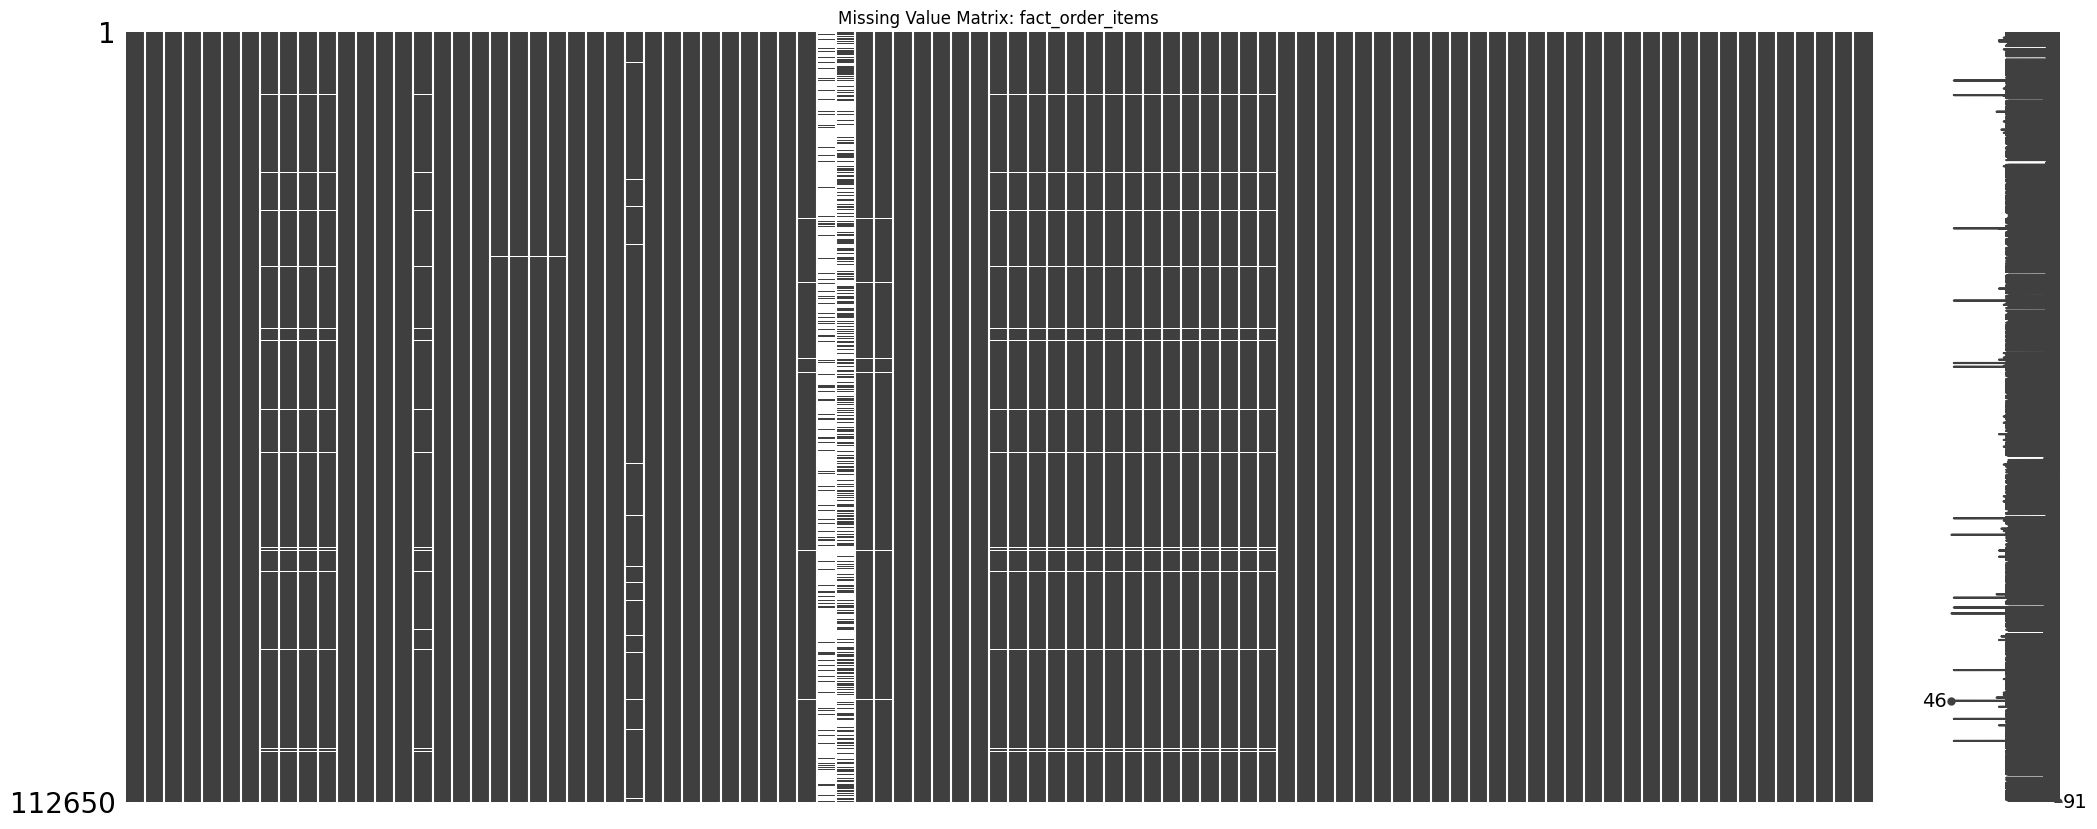

In [57]:
try:

    fact_tables = {
        "fact_order_items": fact_order_items
    }

    for df_name, df in fact_tables.items():
        print(f"\nMissing value matrix for '{df_name}' dataframe:")
        msno.matrix(df)
        plt.title(f"Missing Value Matrix: {df_name}")
        plt.show()

except ImportError:
    print("The 'missingno' library is not installed. Please install it using: pip install missingno")
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna().T, cbar=False, cmap="Blues")
    plt.title(f"Mapa simple de faltantes ({df_name} - all columns)")
    plt.ylabel("Variables")
    plt.xlabel("Observaciones")
    plt.show()
except Exception as e:
    print(f"An error occurred while generating the missing value matrix: {e}")
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna().T, cbar=False, cmap="Blues")
    plt.title(f"Mapa simple de faltantes ({df_name} - all columns)")
    plt.ylabel("Variables")
    plt.xlabel("Observaciones")
    plt.show()

Podemos ver que las columnas de titulo de la review y la review en si tienen muchos valores nulos, y como no vamos a hacer analisis de texto, decidimos eliminarlas.

In [58]:
columns_to_drop = ['review_comment_title', 'review_comment_message']

fact_order_items = fact_order_items.drop(columns=columns_to_drop)

print("Columns dropped successfully.")
print("Shape of fact_order_items after dropping columns:", fact_order_items.shape)

Columns dropped successfully.
Shape of fact_order_items after dropping columns: (112650, 89)


In [59]:
def littles_mcar_test(df):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    exclude_cols = ['order_id', 'customer_id', 'review_comment_title', 'review_comment_message',
                    'order_item_id', 'product_id', 'seller_id', 'customer_unique_id',
                    'customer_zip_code_prefix', 'seller_zip_code_prefix']

    use_cols = [col for col in numerical_cols if col not in exclude_cols]

    if not use_cols:
        print("No suitable numerical columns found for MCAR test.")
        return np.nan, 0, np.nan


    X = df[use_cols].copy().replace({pd.NA: np.nan})

    missing_mask = X.isna()

    imp_mean = SimpleImputer(strategy="mean")
    X_imp = pd.DataFrame(imp_mean.fit_transform(X), columns=use_cols, index=X.index)

    patterns = missing_mask.drop_duplicates()
    chi_square = 0.0
    dof = 0

    for _, pattern in patterns.iterrows():
        rows = missing_mask.eq(pattern, axis=1).all(axis=1)
        subset = X.loc[rows]
        if subset.empty:
            continue

        means = X_imp.loc[rows, use_cols].mean()
        diffs = subset[use_cols].fillna(0) - means

        chi_square += (diffs**2).to_numpy().sum()
        dof += diffs.size

    p_value = 1 - chi2.cdf(chi_square, dof) if dof > 0 else np.nan
    return chi_square, dof, p_value

print("Performing Little's MCAR test on fact_order_items:")
chi2_stat_items, dof_items, p_items = littles_mcar_test(fact_order_items)
print(f"Chi2: {chi2_stat_items:.2f}")
print(f"Grados de libertad: {dof_items}")
print(f"p-valor: {p_items:.4f}")

if np.isnan(p_items):
     print("Could not calculate p-value for fact_order_items (dof=0).")
elif p_items < 0.05:
    print("Reject H0 (Missingness is NOT MCAR) for fact_order_items.")
else:
    print("Fail to reject H0 (Missingness is MCAR) for fact_order_items.")

Performing Little's MCAR test on fact_order_items:
Chi2: 15648182003031.68
Grados de libertad: 7547550
p-valor: 0.0000
Reject H0 (Missingness is NOT MCAR) for fact_order_items.


In [60]:
# se rechaza que sean MCAR, ahora vamos a ver si hay indicios de MAR
# para eso hacemos regresion

def logit_missing(df, target_col, original_numerical_cols):
    y = df[target_col].isna().astype(int)

    exclude_cols_predictors = [target_col, 'order_id', 'customer_id', 'order_item_id',
                               'product_id', 'seller_id', 'customer_unique_id',
                               'customer_zip_code_prefix', 'seller_zip_code_prefix',
                               'delivery_days', 'delivery_days_real',
                               'delivery_delay_orig']


    use_cols_predictors = [col for col in original_numerical_cols if col != target_col and col not in exclude_cols_predictors]

    if not use_cols_predictors:
        print(f"No suitable original numerical columns found to use as predictors for {target_col}.")
        return None

    X_num = df[use_cols_predictors].apply(pd.to_numeric, errors="coerce").astype(float)

    X = sm.add_constant(X_num, has_constant="add")

    mask = X.notna().all(axis=1) & y.notna()
    X2, y2 = X.loc[mask], y.loc[mask]

    if X2.empty or len(X2.columns) < 2:
         print(f"Not enough valid data or predictors to build a model for {target_col}.")
         return None


    # Logit model fitting
    try:
        X2 = X2.dropna(axis=1)
        if X2.empty:
            print(f"No valid predictor columns remaining after dropping NaNs for {target_col}.")
            return None
        y2 = y.loc[X2.index].astype(int)
        modelo = sm.Logit(y2, X2).fit(disp=0)
        print(f"\n=== Logit missing({target_col}) ===")
        print(modelo.summary())
        return modelo
    except Exception as e:
        print(f"Could not build Logit model for {target_col}: {e}")
        return None

current_numerical_cols_items = fact_order_items.select_dtypes(include=np.number).columns.tolist()
original_numerical_cols_items = [col for col in current_numerical_cols_items if not any(keyword in col for keyword in ['boxcox', 'yeojohnson', 'z_score', 'cleaned', '_orig', 'delivery_days', 'delivery_delay', 'delivery_days_real', 'delivery_delay_orig'])]


missing_cols_items_numerical_original = [col for col in fact_order_items.columns[fact_order_items.isna().any()].tolist() if col in original_numerical_cols_items]

print("Analyzing missingness in fact_order_items using only original non-date numerical predictors:")
logit_models_items = {}
for col in missing_cols_items_numerical_original:
    model = logit_missing(fact_order_items, col, original_numerical_cols_items)
    if model:
        logit_models_items[col] = model

Analyzing missingness in fact_order_items using only original non-date numerical predictors:
Could not build Logit model for product_name_lenght: Singular matrix

=== Logit missing(product_description_lenght) ===
                               Logit Regression Results                               
Dep. Variable:     product_description_lenght   No. Observations:               109570
Model:                                  Logit   Df Residuals:                   109554
Method:                                   MLE   Df Model:                           15
Date:                        Wed, 19 Nov 2025   Pseudo R-squ.:                     inf
Time:                                17:59:19   Log-Likelihood:            -4.2696e-09
converged:                              False   LL-Null:                        0.0000
Covariance Type:                    nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975

In [61]:
def interpret_mar_logit_results(model, col_name, alpha=0.05):
    if model is None:
        print("Model was not successfully fitted, cannot interpret results for", col_name)
        return

    print(f"\nInterpretation for missingness in '{col_name}':")

    significant_predictors = []
    for param, p_value in model.pvalues.items():
        if param != 'const' and p_value < alpha:
            significant_predictors.append(param)

    if significant_predictors:
        print(f"Evidence for MAR: Missingness in '{col_name}' is significantly related to the following predictors (p < {alpha}):")
        for predictor in significant_predictors:
            print(f"- {predictor} (p-value: {model.pvalues[predictor]:.4f})")
    else:
        print(f"No significant relationship found between missingness in '{col_name}' and the included numerical predictors (at alpha={alpha}).")
        print("This *could* be an indication of MNAR for this column, but it's not conclusive.")
        print("Missingness might be related to other variables not included or the missing value itself.")

print("\nInterpreting MAR analysis results for fact_order_items:")
for col, model in logit_models_items.items():
    interpret_mar_logit_results(model, col)
    print("-" * 50)


Interpreting MAR analysis results for fact_order_items:

Interpretation for missingness in 'product_description_lenght':
No significant relationship found between missingness in 'product_description_lenght' and the included numerical predictors (at alpha=0.05).
This *could* be an indication of MNAR for this column, but it's not conclusive.
Missingness might be related to other variables not included or the missing value itself.
--------------------------------------------------

Interpretation for missingness in 'product_weight_g':
No significant relationship found between missingness in 'product_weight_g' and the included numerical predictors (at alpha=0.05).
This *could* be an indication of MNAR for this column, but it's not conclusive.
Missingness might be related to other variables not included or the missing value itself.
--------------------------------------------------

Interpretation for missingness in 'product_length_cm':
No significant relationship found between missingness

Hicimos la regresión logística sobre las variables numéricas. En la mayoría de los casos,no rechazamos H0 (todos los p valores eran grandes), por lo que no podíamos afirmar que los datos fueran MAR.

Entonces, consideramos que al tratarse de una cantidad menor al 3% de faltantes por columna, aplicamos KNN en todos los casos porque no consideramos que el test fuera tan concluyente ya que la cantidad de datos faltantes era poca.

En conclusión, aplicamos KNN en todos los casos, en las columnas no numéricas de texto imputamos con la moda y en las de fecha y hora rellenamos con NaT, que es un dato nulo pero de tiempo.

In [62]:
numerical_cols_with_missing_items = fact_order_items.select_dtypes(include=np.number).columns[fact_order_items.select_dtypes(include=np.number).isna().any()].tolist()
exclude_cols_impute_items = ['order_item_id', 'customer_zip_code_prefix', 'seller_zip_code_prefix']

numerical_cols_to_impute_knn_items = [col for col in numerical_cols_with_missing_items if col not in exclude_cols_impute_items]

print("\nApplying KNN imputation to numerical columns in fact_order_items:")
if numerical_cols_to_impute_knn_items:
    imputer_items = KNNImputer(n_neighbors=5)
    fact_order_items[numerical_cols_to_impute_knn_items] = imputer_items.fit_transform(fact_order_items[numerical_cols_to_impute_knn_items])
    print("KNN imputation applied to:", numerical_cols_to_impute_knn_items)
else:
    print("No suitable numerical columns found in fact_order_items for KNN imputation.")


Applying KNN imputation to numerical columns in fact_order_items:
KNN imputation applied to: ['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng', 'payment_value_total', 'payment_installments_max', 'review_score', 'boxcox_product_name_lenght', 'z_score_product_name_lenght_boxcox', 'z_score_product_name_lenght', 'boxcox_imputed_product_name_lenght', 'cleaned_product_name_lenght', 'boxcox_product_description_lenght', 'z_score_product_description_lenght_boxcox', 'z_score_product_description_lenght', 'boxcox_imputed_product_description_lenght', 'cleaned_product_description_lenght', 'boxcox_product_photos_qty', 'z_score_product_photos_qty_boxcox', 'z_score_product_photos_qty', 'boxcox_imputed_product_photos_qty', 'cleaned_product_photos_qty', 'boxcox_product_length_cm', 'z_score_product_length_cm_boxcox', 'z_score_product_length

In [63]:
categorical_cols_to_impute_mode_items = ['product_category_name_english', 'product_category_name', 'seller_geo_city', 'seller_geo_state', 'payment_type_mode']

print("\nApplying mode imputation to categorical columns in fact_order_items:")
for col in categorical_cols_to_impute_mode_items:
    if col in fact_order_items.columns and fact_order_items[col].isna().any():
        mode_value = fact_order_items[col].mode()[0]
        fact_order_items[col] = fact_order_items[col].fillna(mode_value)
        print(f"Mode imputation applied to '{col}' in fact_order_items.")
    elif col not in fact_order_items.columns:
         print(f"Column '{col}' not found in fact_order_items. Skipping mode imputation.")
    else:
         print(f"Column '{col}' in fact_order_items has no missing values. Skipping mode imputation.")


Applying mode imputation to categorical columns in fact_order_items:
Mode imputation applied to 'product_category_name_english' in fact_order_items.
Mode imputation applied to 'product_category_name' in fact_order_items.
Mode imputation applied to 'seller_geo_city' in fact_order_items.
Mode imputation applied to 'seller_geo_state' in fact_order_items.
Mode imputation applied to 'payment_type_mode' in fact_order_items.


In [64]:
date_cols_to_impute_items = ['order_delivered_customer_date', 'review_creation_date', 'review_answer_timestamp']

print("\nApplying NaT imputation to date/time columns in fact_order_items:")
for col in date_cols_to_impute_items:
     if col in fact_order_items.columns and fact_order_items[col].isna().any():
        fact_order_items[col] = pd.to_datetime(fact_order_items[col], errors='coerce')
        fact_order_items[col] = fact_order_items[col].fillna(pd.NaT)
        print(f"NaT imputation applied to '{col}' in fact_order_items.")
     elif col not in fact_order_items.columns:
        print(f"Column '{col}' not found in fact_order_items. Skipping NaT imputation.")
     else:
        print(f"Column '{col}' in fact_order_items has no missing values. Skipping NaT imputation.")


Applying NaT imputation to date/time columns in fact_order_items:
NaT imputation applied to 'order_delivered_customer_date' in fact_order_items.
NaT imputation applied to 'review_creation_date' in fact_order_items.
NaT imputation applied to 'review_answer_timestamp' in fact_order_items.


In [65]:
fact_tables = {
    "fact_order_items": fact_order_items
}

print("Checking for any remaining missing values in fact tables after imputation:")

all_missing_handled = True
for df_name, df in fact_tables.items():
    n = len(df)
    falt = df.isna().sum()
    falt = falt[falt > 0]

    if not falt.empty:
        all_missing_handled = False
        falt_pct = (falt / n) * 100
        faltantes_df = (
            pd.DataFrame({"Cantidad_faltantes": falt, "Porcentaje": falt_pct})
            .sort_values("Porcentaje", ascending=False)
        )
        faltantes_df["Porcentaje"] = faltantes_df["Porcentaje"].map(lambda x: f"{x:.2f}%")
        print(f"\nRemaining missing values found in '{df_name}' dataframe:")
        display(faltantes_df)
    else:
        print(f"\nNo remaining missing values found in '{df_name}' dataframe.")

if all_missing_handled:
    print("\nAll intended missing values appear to have been handled.")
else:
    print("\nThere are still some missing values that may need further attention.")

Checking for any remaining missing values in fact tables after imputation:

Remaining missing values found in 'fact_order_items' dataframe:


,Cantidad_faltantes,Porcentaje
order_delivered_customer_date,2454,2.18%
review_creation_date,942,0.84%
review_answer_timestamp,942,0.84%



There are still some missing values that may need further attention.


##Análisis exploratorio inicial con visualizaciones.

###Gráficos básicos que permitan contrastar hipótesis de la entrega 1. Conclusiones preliminares.

**Hipótesis 1, 2 y 3**: Se encuentran en la notebook "TP_descriptiva_Fact_Orders"

**Hipótesis 4**: Un % de flete alto (sobre el precio) incrementa las cancelaciones y baja la satisfacción.

**Conclusiones**: Podemos ver que hay diferencia entre el % de flete sobre el precio según el estado del envío, si fue enviado o cancelado.

Podemos ver que no se pueden sacar conclusiones a la vista acerca de si un mayor % de flete alto baja la satisfacción. Hay muchos casos de reviews altas con % de flete altos.

Las visualizaciones proporcionan cierta evidencia visual que apoya la idea de que un porcentaje de flete más alto podría estar relacionado con las cancelaciones. Sin embargo, la relación entre un porcentaje de flete alto y una menor satisfacción del cliente (basada en la puntuación de la reseña) no parece ser tan clara a simple vista y puede que no haya suficiente evidencia visual para respaldar esa parte de la hipótesis. Se necesitaría un análisis estadístico más riguroso para confirmar estas observaciones preliminares.

In [66]:
fact_order_items['freight_percentage'] = (fact_order_items['freight_value'] / (fact_order_items['price'] + 1e-6)) * 100

print("Freight percentage calculated and added to fact_order_items.")
display(fact_order_items[['price', 'freight_value', 'freight_percentage']].head())

Freight percentage calculated and added to fact_order_items.


,price,freight_value,freight_percentage
0,58.90,13.29,22.563667
1,239.90,19.93,8.307628
2,199.00,17.87,8.979899
3,12.99,12.79,98.460347
4,199.90,18.14,9.074537



Exploring relationship between Freight Percentage and Satisfaction Level (Review Score):


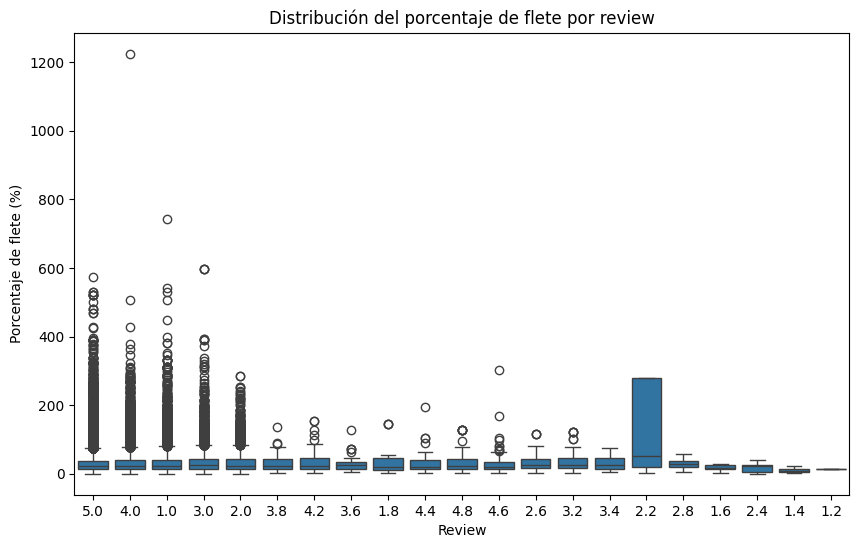

In [67]:
if 'review_score' in fact_order_items.columns:
    items_for_satisfaction = fact_order_items.dropna(subset=['review_score']).copy()

    print("\nExploring relationship between Freight Percentage and Satisfaction Level (Review Score):")
    plt.figure(figsize=(10, 6))
    items_for_satisfaction['review_score_str'] = items_for_satisfaction['review_score'].astype(str)
    sns.boxplot(data=items_for_satisfaction, x='review_score_str', y='freight_percentage')
    plt.title('Distribución del porcentaje de flete por review')
    plt.xlabel('Review')
    plt.ylabel('Porcentaje de flete (%)')
    plt.show()

else:
    print("The 'review_score' column is not available in fact_order_items to explore this relationship.")

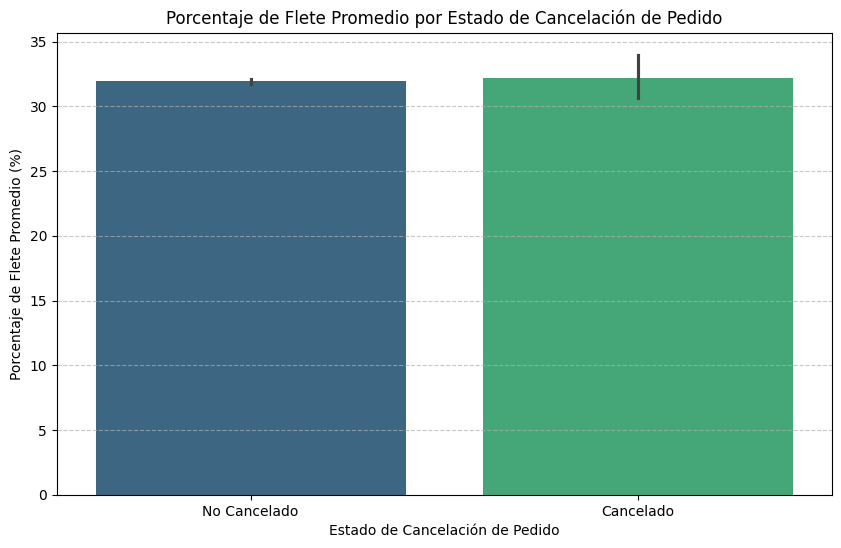

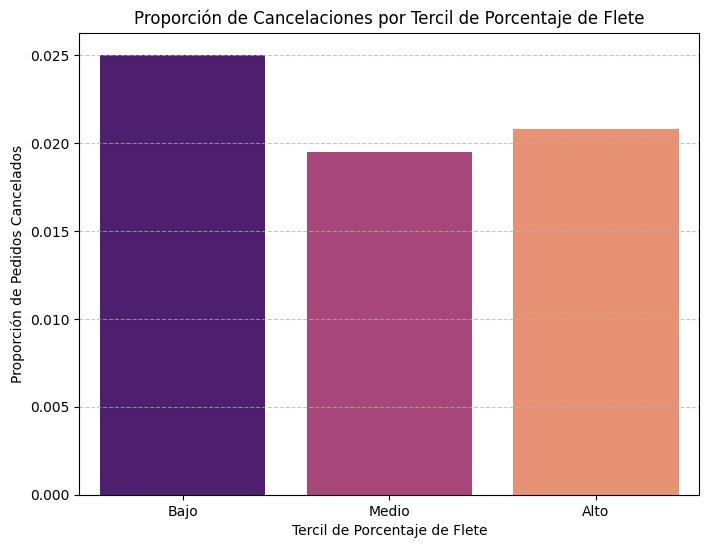

In [68]:
if 'is_canceled' not in df.columns:
    # Asumimos que 'order_delivered_customer_date' es la columna que indica la entrega.
    # Si es nula, el pedido se considera 'cancelado' (o no entregado/no finalizado).
    df['is_canceled'] = df['order_delivered_customer_date'].isna().astype(int)


if 'freight_tercile' not in df.columns:
    # Asegurarse de que 'freight_percentage' exista y no tenga nulos críticos para qcut
    df_temp = df.dropna(subset=['freight_percentage']).copy()
    if len(df_temp) > 0:
        df['freight_tercile'] = pd.qcut(df_temp['freight_percentage'], q=3, labels=['Bajo','Medio','Alto'])
    else:
        df['freight_tercile'] = None # O manejar de otra forma si no hay datos

# Barplot para el porcentaje de flete promedio vs. cancelación
plt.figure(figsize=(10, 6))
sns.barplot(x='is_canceled', y='freight_percentage', data=df, palette='viridis', estimator=np.mean)
plt.title('Porcentaje de Flete Promedio por Estado de Cancelación de Pedido')
plt.xlabel('Estado de Cancelación de Pedido')
plt.ylabel('Porcentaje de Flete Promedio (%)')
plt.xticks([0, 1], ['No Cancelado', 'Cancelado'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

cancellation_proportions = df.groupby('freight_tercile')['is_canceled'].mean().reset_index()
cancellation_proportions['freight_tercile'] = pd.Categorical(cancellation_proportions['freight_tercile'], categories=['Bajo', 'Medio', 'Alto'], ordered=True)
cancellation_proportions = cancellation_proportions.sort_values('freight_tercile')

plt.figure(figsize=(8, 6))
sns.barplot(x='freight_tercile', y='is_canceled', data=cancellation_proportions, palette='magma')
plt.title('Proporción de Cancelaciones por Tercil de Porcentaje de Flete')
plt.xlabel('Tercil de Porcentaje de Flete')
plt.ylabel('Proporción de Pedidos Cancelados')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Preprocesamiento para Machine Learning

## Correlación

In [69]:
numerical_cols = fact_order_items.select_dtypes(include=np.number).columns.tolist()

exclude_prefixes = [
    'z_score_', 'boxcox_', 'yeojohnson_', 'cleaned_', 'boxcox_imputed_',
    'z_score_product_name_lenght', 'z_score_product_description_lenght',
    'z_score_product_photos_qty', 'z_score_product_weight_g',
    'z_score_product_length_cm', 'z_score_product_height_cm',
    'z_score_product_width_cm', 'z_score_payment_value_total',
    'z_score_freight_value_yeojohnson', 'z_score_freight_value'
]

specific_excludes = [
    'order_item_id', 'seller_zip_code_prefix', 'customer_zip_code_prefix',
    'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng',
    'freight_percentage'
]

exclusion_set = set(specific_excludes)
for col in numerical_cols:
    for prefix in exclude_prefixes:
        if col.startswith(prefix):
            exclusion_set.add(col)


correlation_cols = []
processed_orig_cols = set()

for col in numerical_cols:
    if col.endswith('_orig'):
        base_col = col.replace('_orig', '')
        if base_col not in processed_orig_cols and base_col not in exclusion_set:
            correlation_cols.append(col)
            processed_orig_cols.add(base_col)
    elif col not in exclusion_set and col not in processed_orig_cols:
        if f"{col}_orig" not in numerical_cols or f"{col}_orig" in exclusion_set:
            correlation_cols.append(col)

correlation_cols = [col for col in correlation_cols if col not in exclusion_set]

print("Columns selected for correlation analysis:", correlation_cols)
print("Number of columns selected:", len(correlation_cols))

Columns selected for correlation analysis: ['price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_installments_max', 'review_score', 'freight_value_orig', 'product_weight_g_orig', 'payment_value_total_orig', 'is_canceled']
Number of columns selected: 13


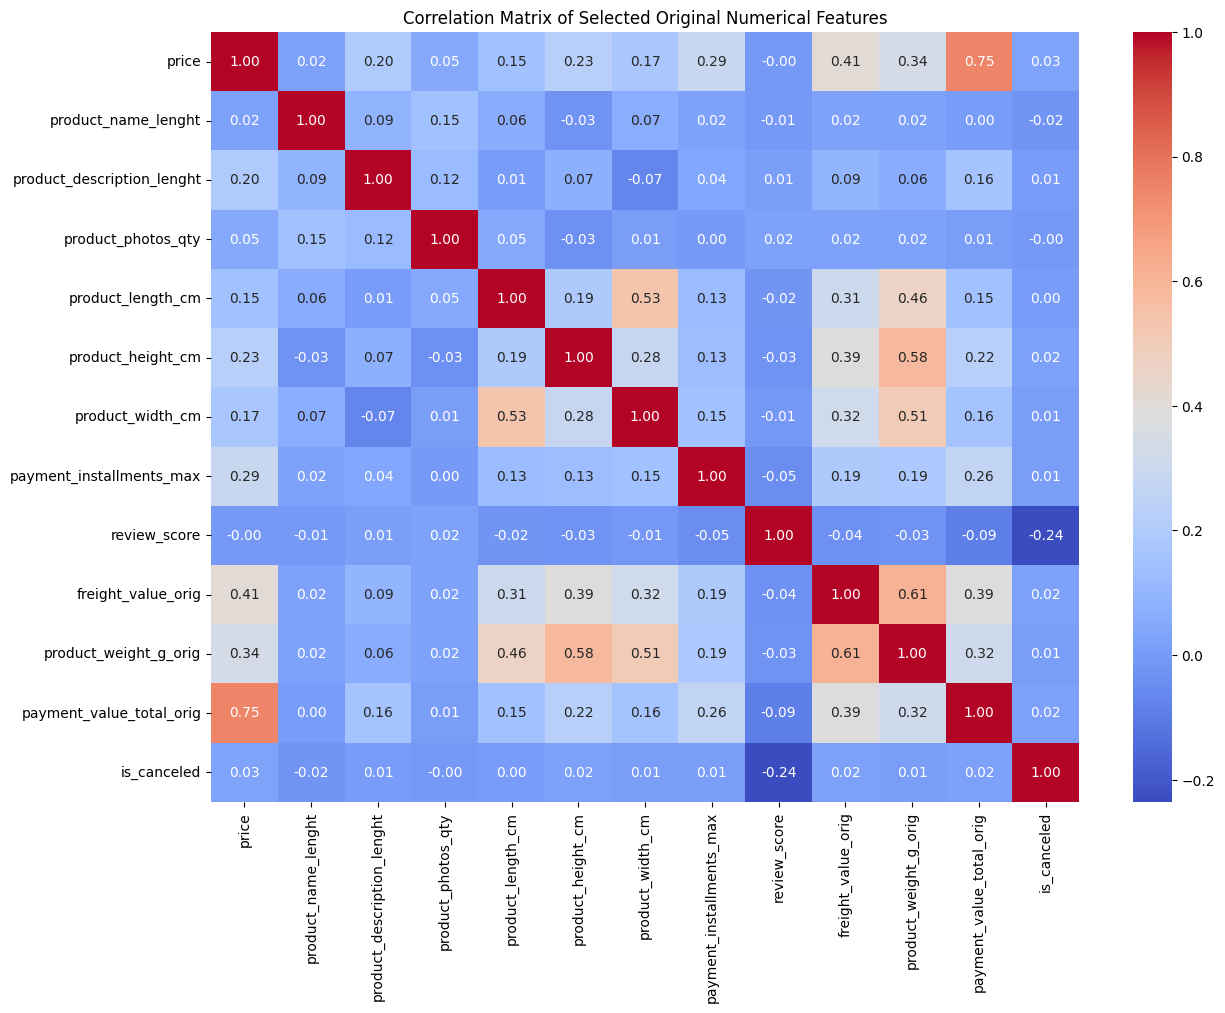

In [70]:
selected_df = fact_order_items[correlation_cols].copy()
corr_matrix = selected_df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Original Numerical Features')
plt.show()

No hay variables altamente correlacionadas es por eso que decidimos mantener todas.

## Encoding de variables categóricas

In [71]:
categorical_cols = fact_order_items.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical variables in fact_orders:")
print(categorical_cols)

# los ids no van a ser categoricos

Categorical variables in fact_orders:
['order_id', 'product_id', 'seller_id', 'product_category_name', 'product_category_name_english', 'seller_city', 'seller_state', 'seller_geo_city', 'seller_geo_state', 'customer_id', 'customer_state', 'customer_city', 'payment_type_mode', 'freight_tercile']


In [72]:
fact_order_items['product_category_name'].nunique()

73

In [73]:
fact_order_items['seller_state'].nunique()

23

In [74]:
fact_order_items['seller_geo_city'].nunique()

557

In [75]:
fact_order_items['seller_geo_state'].nunique()

22

In [76]:
fact_order_items['customer_state'].nunique()

27

In [77]:
fact_order_items['customer_city'].nunique()

4110

In [78]:
fact_order_items['payment_type_mode'].nunique()
# esta es la unica categorica

4

In [79]:
fact_order_items['payment_type_mode'].unique()

array(['credit_card', 'boleto', 'debit_card', 'voucher'], dtype=object)

De las variables categóricas vamos a analizar solamente las que tengan menos de 15 categorías. En este caso, sería 'payment_type_mode'.

### One Hot Encoder

In [80]:
numerical_cols_for_modeling_cleaned = [col for col in correlation_cols if not any(prefix in col for prefix in ['z_score_', 'boxcox_', 'yeojohnson_', 'cleaned_'])]
categorical_cols_for_modeling = ['payment_type_mode']

fact_order_items_model = fact_order_items[categorical_cols_for_modeling + numerical_cols_for_modeling_cleaned].copy()

print("DataFrame para el modelado creado con la forma:", fact_order_items_model.shape)
display(fact_order_items_model.head())

DataFrame para el modelado creado con la forma: (112650, 14)


,payment_type_mode,price,product_name_lenght,product_description_lenght,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,payment_installments_max,review_score,freight_value_orig,product_weight_g_orig,payment_value_total_orig,is_canceled
0,credit_card,58.90,58.0,598.0,4.0,28.0,9.0,14.0,2.0,5.0,13.29,650.0,72.19,0
1,credit_card,239.90,56.0,239.0,2.0,50.0,30.0,40.0,3.0,4.0,19.93,30000.0,259.83,0
2,credit_card,199.00,59.0,695.0,2.0,33.0,13.0,33.0,5.0,5.0,17.87,3050.0,216.87,0
3,credit_card,12.99,42.0,480.0,1.0,16.0,10.0,15.0,2.0,4.0,12.79,200.0,25.78,0
4,credit_card,199.90,59.0,409.0,1.0,35.0,40.0,30.0,3.0,5.0,18.14,3750.0,218.04,0


In [81]:
# Aplicar OneHotEncoder a las columnas categóricas
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Usar sparse_output=False para una salida densa
onehot_encoded_cols = encoder.fit_transform(fact_order_items_model[categorical_cols_for_modeling])

# Crear un DataFrame con las columnas codificadas con One-Hot
onehot_df = pd.DataFrame(onehot_encoded_cols, columns=encoder.get_feature_names_out(categorical_cols_for_modeling), index=fact_order_items_model.index)

# Eliminar las columnas categóricas originales y concatenar el DataFrame codificado
fact_order_items_model_encoded = fact_order_items_model.drop(columns=categorical_cols_for_modeling)
fact_order_items_model_encoded = pd.concat([fact_order_items_model_encoded, onehot_df], axis=1)

print("One-hot encoding aplicado. Forma del DataFrame codificado:", fact_order_items_model_encoded.shape)
display(fact_order_items_model_encoded.head())

One-hot encoding aplicado. Forma del DataFrame codificado: (112650, 17)


,price,product_name_lenght,product_description_lenght,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,payment_installments_max,review_score,freight_value_orig,product_weight_g_orig,payment_value_total_orig,is_canceled,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_voucher
0,58.90,58.0,598.0,4.0,28.0,9.0,14.0,2.0,5.0,13.29,650.0,72.19,0,0.0,1.0,0.0,0.0
1,239.90,56.0,239.0,2.0,50.0,30.0,40.0,3.0,4.0,19.93,30000.0,259.83,0,0.0,1.0,0.0,0.0
2,199.00,59.0,695.0,2.0,33.0,13.0,33.0,5.0,5.0,17.87,3050.0,216.87,0,0.0,1.0,0.0,0.0
3,12.99,42.0,480.0,1.0,16.0,10.0,15.0,2.0,4.0,12.79,200.0,25.78,0,0.0,1.0,0.0,0.0
4,199.90,59.0,409.0,1.0,35.0,40.0,30.0,3.0,5.0,18.14,3750.0,218.04,0,0.0,1.0,0.0,0.0


## Estandarización

In [82]:
# Identificar las columnas numéricas después del one-hot encoding
numerical_cols_after_encoding = fact_order_items_model_encoded.select_dtypes(include=np.number).columns.tolist()

# Aplicar StandardScaler a las columnas numéricas
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(fact_order_items_model_encoded[numerical_cols_after_encoding])

# Crear un DataFrame con los datos escalados
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_cols_after_encoding, index=fact_order_items_model_encoded.index)

# Reemplazar las columnas numéricas originales con las escaladas
for col in numerical_cols_after_encoding:
    fact_order_items_model_encoded[col] = scaled_numerical_df[col]

print("Estandarización aplicada. Forma final del DataFrame preprocesado:", fact_order_items_model_encoded.shape)
display(fact_order_items_model_encoded.head())

Estandarización aplicada. Forma final del DataFrame preprocesado: (112650, 17)


,price,product_name_lenght,product_description_lenght,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,payment_installments_max,review_score,freight_value_orig,product_weight_g_orig,payment_value_total_orig,is_canceled,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_voucher
0,-0.341241,0.924946,-0.291140,1.045341,-0.133656,-0.564847,-0.768438,-0.363398,0.699500,-0.423901,-0.384782,-0.396154,-0.149229,-0.50467,0.556398,-0.123376,-0.136954
1,0.661514,0.724691,-0.843950,-0.121885,1.228769,0.997346,1.452540,-0.006575,-0.022627,-0.003816,7.439094,0.291563,-0.149229,-0.50467,0.556398,-0.123376,-0.136954
2,0.434925,1.025073,-0.141774,-0.121885,0.175986,-0.267286,0.854584,0.707070,0.699500,-0.134144,0.254989,0.134111,-0.149229,-0.50467,0.556398,-0.123376,-0.136954
3,-0.595586,-0.677090,-0.472844,-0.705497,-0.876797,-0.490457,-0.683015,-0.363398,-0.022627,-0.455534,-0.504740,-0.566251,-0.149229,-0.50467,0.556398,-0.123376,-0.136954
4,0.439911,1.025073,-0.582174,-0.705497,0.299843,1.741247,0.598318,-0.006575,0.699500,-0.117062,0.441590,0.138399,-0.149229,-0.50467,0.556398,-0.123376,-0.136954


## PCA

Valores nulos en X_scaled antes de PCA:
No se encontraron valores nulos en X_scaled.


,Componente,Varianza_Individual,Varianza_Acumulada
0,PC1,1.968109e-01,0.196811
1,PC2,1.256794e-01,0.322490
2,PC3,8.752543e-02,0.410016
3,PC4,7.430077e-02,0.484317
4,PC5,6.991667e-02,0.554233
5,PC6,6.146170e-02,0.615695
6,PC7,5.976218e-02,0.675457
7,PC8,5.523353e-02,0.730691
8,PC9,5.035423e-02,0.781045
9,PC10,4.710906e-02,0.828154


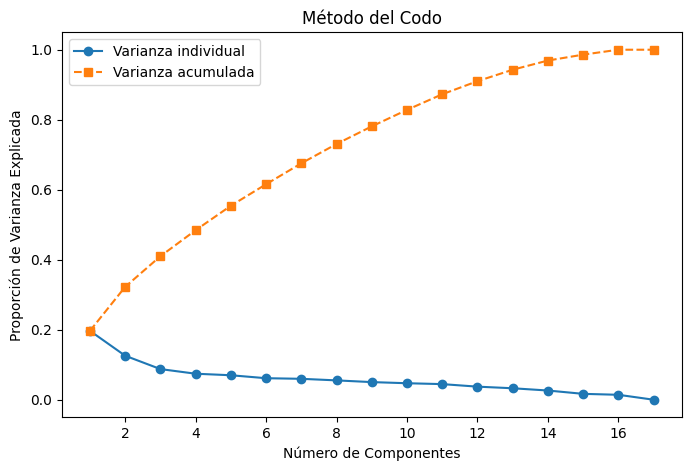

In [83]:
pca = PCA()

X_scaled = fact_order_items_model_encoded.copy()

print("Valores nulos en X_scaled antes de PCA:")
missing_values_before_pca = X_scaled.isnull().sum()[X_scaled.isnull().sum() > 0]
if not missing_values_before_pca.empty:
    display(missing_values_before_pca)
else:
    print("No se encontraron valores nulos en X_scaled.")

pca.fit(X_scaled)

explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

pca_results = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(explained_var))],
    'Varianza_Individual': explained_var,
    'Varianza_Acumulada': cum_var
})

display(pca_results)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, 'o-', label='Varianza individual')
plt.plot(range(1, len(cum_var)+1), cum_var, 's--', label='Varianza acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Método del Codo')
plt.legend()
plt.show()

In [84]:
# Autovalores (eigenvalues) del PCA en los datos escalados
# En scikit-learn, explained_variance_ ya representa los autovalores de la matriz de covarianza de los datos escalados
eigenvalues_scaled = pca.explained_variance_

print("Autovalores de los datos escalados (comparables al criterio de Kaiser > 1):")
for i, eigenvalue in enumerate(eigenvalues_scaled):
    print(f"Componente PC{i+1}: {eigenvalue:.4f}") # Criterio de Kaiser (Autovalor > 1) - Aplicado correctamente a los autovalores de los datos escalados
print("\nAutovalores mayores a 1 (Aplicando Criterio de Kaiser a autovalores de datos escalados):")
components_kaiser = [i + 1 for i, eigenvalue in enumerate(eigenvalues_scaled) if eigenvalue > 1]

if components_kaiser:
    for comp in components_kaiser:
        print(f"Componente PC{comp}: {eigenvalues_scaled[comp-1]:.4f}")
else:
    print("Ningún autovalor es mayor a 1 según el criterio de Kaiser.")

# El número de componentes a retener según Kaiser sería la longitud de la lista components_kaiser.
print(f"\nNúmero de componentes a retener según el Criterio de Kaiser: {len(components_kaiser)}")

Autovalores de los datos escalados (comparables al criterio de Kaiser > 1):
Componente PC1: 3.3458
Componente PC2: 2.1366
Componente PC3: 1.4879
Componente PC4: 1.2631
Componente PC5: 1.1886
Componente PC6: 1.0449
Componente PC7: 1.0160
Componente PC8: 0.9390
Componente PC9: 0.8560
Componente PC10: 0.8009
Componente PC11: 0.7580
Componente PC12: 0.6349
Componente PC13: 0.5567
Componente PC14: 0.4468
Componente PC15: 0.2855
Componente PC16: 0.2394
Componente PC17: 0.0000

Autovalores mayores a 1 (Aplicando Criterio de Kaiser a autovalores de datos escalados):
Componente PC1: 3.3458
Componente PC2: 2.1366
Componente PC3: 1.4879
Componente PC4: 1.2631
Componente PC5: 1.1886
Componente PC6: 1.0449
Componente PC7: 1.0160

Número de componentes a retener según el Criterio de Kaiser: 7


Vamos a elegir 6 componentes principales por el criterio de Kaiser

# Clustering

## Método del codo

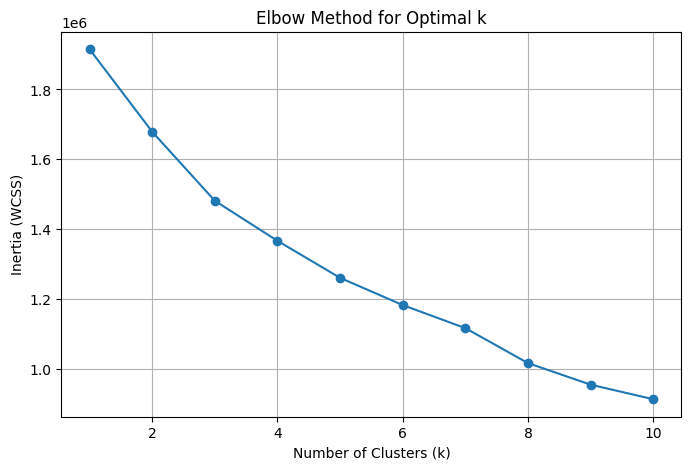

Observación: No se observa un codo claro en el gráfico de inercia.


In [88]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

print("Observación: No se observa un codo claro en el gráfico de inercia.")

## Método de Silhoutte

In [89]:
silhouette_scores = []
k_range = range(2, 11) # Silhouette score requiere al menos 2 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.show()

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
max_silhouette_score = np.max(silhouette_scores)

print(f"El valor máximo del coeficiente de silueta es {max_silhouette_score:.2f} en {optimal_k_silhouette} clusters.")
print("Observación: El valor de silueta es relativamente bajo, lo que indica clusters poco definidos o superpuestos.")

KeyboardInterrupt: 

## Método de VRC (Calinski-Harabasz Score)

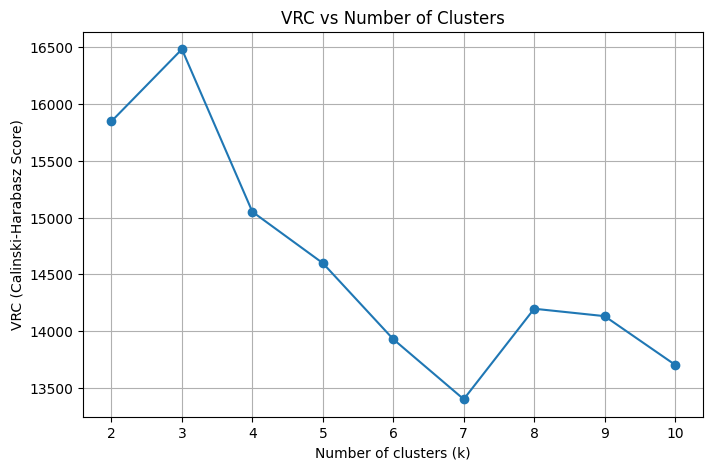

El pico del índice VRC se encuentra en 3 clusters, con un valor de 16479.60.


In [85]:
k_values = range(2, 11)
vrc_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) # Usar n_init=10 para consistencia
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    vrc_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, vrc_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('VRC (Calinski-Harabasz Score)')
plt.title('VRC vs Number of Clusters')
plt.grid(True)
plt.show()

optimal_k_vrc = k_values[np.argmax(vrc_scores)]
max_vrc_score = np.max(vrc_scores)

print(f"El pico del índice VRC se encuentra en {optimal_k_vrc} clusters, con un valor de {max_vrc_score:.2f}.")

## KMeans con 3 clusters

In [96]:
pca_final = PCA(n_components=6, random_state=42)
X_pca = pca_final.fit_transform(X_scaled)

print("Shape of X_pca:", X_pca.shape)
print("First 5 rows of X_pca:\n", X_pca[:5])

Shape of X_pca: (112650, 6)
First 5 rows of X_pca:
 [[-1.04319033e+00  8.29307310e-01  7.22301513e-04  1.23840426e+00
   6.42494598e-01 -6.88276968e-02]
 [ 4.81999526e+00 -7.26630197e-01 -2.72531498e+00  2.13889278e-01
   5.14592079e-02 -7.49489727e-03]
 [ 7.80751201e-01  8.29162736e-01 -3.17605805e-01  8.47897010e-01
   1.42049170e-01 -5.78672319e-02]
 [-1.51537963e+00  9.49334354e-01 -1.89601355e-01 -6.16709846e-01
  -7.81629706e-01 -4.95103681e-02]
 [ 1.25061283e+00  3.64388364e-01 -8.41589490e-01  3.51555368e-01
  -4.59983319e-01 -1.88624054e-02]]


Probamos con 3 clusters

In [97]:
# inicializar y ajustar el modelo de kmeans con 3 clusters
kmeans = KMeans(
    n_clusters=3,        # Usamos 3 clusters como se indicó
    n_init=10,           # Número de inicializaciones para encontrar los mejores centroides
    max_iter=300,        # Máximo de iteraciones por inicialización
    random_state=42      # Semilla para reproducibilidad
)

# Ajustar K-Means a los componentes principales de PCA (X_pca)
kmeans.fit(X_pca)

# Agregamos las etiquetas de cluster al DataFrame original para su análisis
# Crear una copia para evitar SettingWithCopyWarning
df_clustered_pca = fact_order_items_model_encoded.copy()
df_clustered_pca['cluster_pca'] = kmeans.labels_

print("K-Means clustering aplicado a los componentes PCA.")
print("Primeras filas del DataFrame con etiquetas de cluster de PCA:")
display(df_clustered_pca.head())

K-Means clustering aplicado a los componentes PCA.
Primeras filas del DataFrame con etiquetas de cluster de PCA:


,price,product_name_lenght,product_description_lenght,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,payment_installments_max,review_score,freight_value_orig,product_weight_g_orig,payment_value_total_orig,is_canceled,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_voucher,cluster_pca
0,-0.341241,0.924946,-0.291140,1.045341,-0.133656,-0.564847,-0.768438,-0.363398,0.699500,-0.423901,-0.384782,-0.396154,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,2
1,0.661514,0.724691,-0.843950,-0.121885,1.228769,0.997346,1.452540,-0.006575,-0.022627,-0.003816,7.439094,0.291563,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,1
2,0.434925,1.025073,-0.141774,-0.121885,0.175986,-0.267286,0.854584,0.707070,0.699500,-0.134144,0.254989,0.134111,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,2
3,-0.595586,-0.677090,-0.472844,-0.705497,-0.876797,-0.490457,-0.683015,-0.363398,-0.022627,-0.455534,-0.504740,-0.566251,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,2
4,0.439911,1.025073,-0.582174,-0.705497,0.299843,1.741247,0.598318,-0.006575,0.699500,-0.117062,0.441590,0.138399,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,2


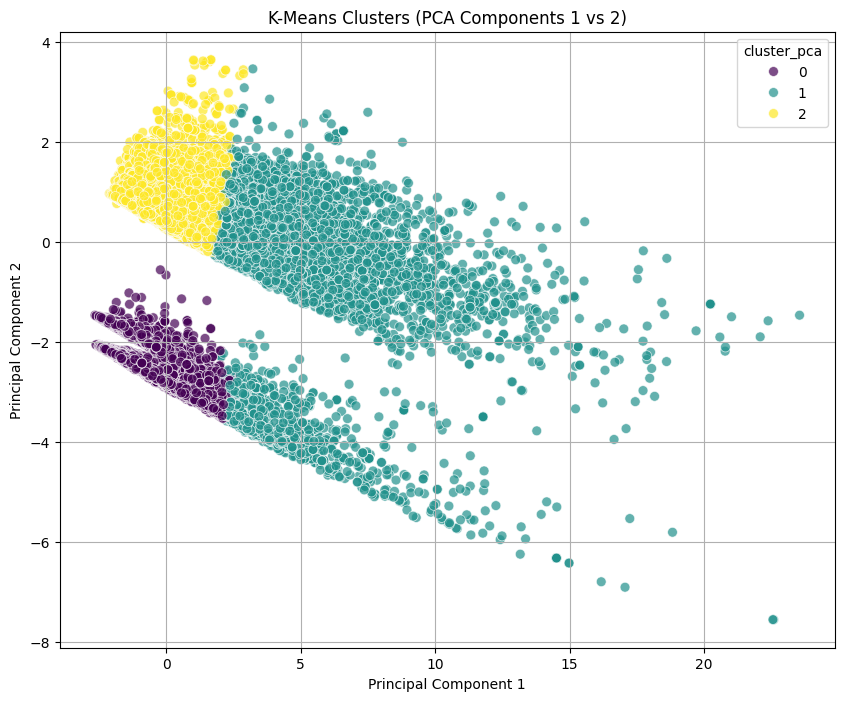

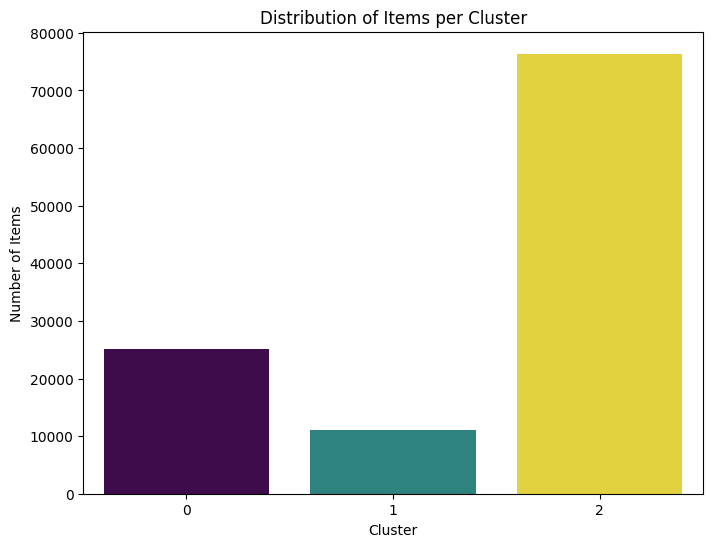

Visualización de clusters completada. Gráfico de dispersión de los dos primeros componentes PCA con etiquetas de cluster y gráfico de barras de la distribución de clusters mostrados.


In [98]:
# Visualización de los clusters en los dos primeros componentes principales
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_clustered_pca['cluster_pca'], palette='viridis', legend='full', s=50, alpha=0.7)
plt.title('K-Means Clusters (PCA Components 1 vs 2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Visualización de la distribución de ítems por cluster
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster_pca', data=df_clustered_pca, hue='cluster_pca', palette='viridis', legend=False) # Se agregó hue y legend=False para evitar el FutureWarning
plt.title('Distribution of Items per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Items')
plt.show()

print("Visualización de clusters completada. Gráfico de dispersión de los dos primeros componentes PCA con etiquetas de cluster y gráfico de barras de la distribución de clusters mostrados.")

## KMeans con 4 clusters

Probamos con 4 clusters

In [99]:
# inicializar y ajustar el modelo de kmeans con 4 clusters
kmeans = KMeans(
    n_clusters=4,        # Usamos 4 clusters como se indicó
    n_init=10,           # Número de inicializaciones para encontrar los mejores centroides
    max_iter=300,        # Máximo de iteraciones por inicialización
    random_state=42      # Semilla para reproducibilidad
)

# Ajustar K-Means a los componentes principales de PCA (X_pca)
kmeans.fit(X_pca)

# Agregamos las etiquetas de cluster al DataFrame original para su análisis
# Crear una copia para evitar SettingWithCopyWarning
df_clustered_pca = fact_order_items_model_encoded.copy()
df_clustered_pca['cluster_pca'] = kmeans.labels_

print("K-Means clustering aplicado a los componentes PCA.")
print("Primeras filas del DataFrame con etiquetas de cluster de PCA:")
display(df_clustered_pca.head())

K-Means clustering aplicado a los componentes PCA.
Primeras filas del DataFrame con etiquetas de cluster de PCA:


,price,product_name_lenght,product_description_lenght,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,payment_installments_max,review_score,freight_value_orig,product_weight_g_orig,payment_value_total_orig,is_canceled,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_voucher,cluster_pca
0,-0.341241,0.924946,-0.291140,1.045341,-0.133656,-0.564847,-0.768438,-0.363398,0.699500,-0.423901,-0.384782,-0.396154,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,2
1,0.661514,0.724691,-0.843950,-0.121885,1.228769,0.997346,1.452540,-0.006575,-0.022627,-0.003816,7.439094,0.291563,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,1
2,0.434925,1.025073,-0.141774,-0.121885,0.175986,-0.267286,0.854584,0.707070,0.699500,-0.134144,0.254989,0.134111,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,2
3,-0.595586,-0.677090,-0.472844,-0.705497,-0.876797,-0.490457,-0.683015,-0.363398,-0.022627,-0.455534,-0.504740,-0.566251,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,2
4,0.439911,1.025073,-0.582174,-0.705497,0.299843,1.741247,0.598318,-0.006575,0.699500,-0.117062,0.441590,0.138399,-0.149229,-0.50467,0.556398,-0.123376,-0.136954,2


In [ ]:
# Visualización de los clusters en los dos primeros componentes principales
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_clustered_pca['cluster_pca'], palette='viridis', legend='full', s=50, alpha=0.7)
plt.title('K-Means Clusters (PCA Components 1 vs 2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Visualización de la distribución de ítems por cluster
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster_pca', data=df_clustered_pca, hue='cluster_pca', palette='viridis', legend=False) # Se agregó hue y legend=False para evitar el FutureWarning
plt.title('Distribution of Items per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Items')
plt.show()

print("Visualización de clusters completada. Gráfico de dispersión de los dos primeros componentes PCA con etiquetas de cluster y gráfico de barras de la distribución de clusters mostrados.")

# RFM
**Recency**: tiempo desde la última compra. Se representa con la variable Recency (valores más bajos = más recientes).

**Frequency**: cantidad de compras realizadas.

**Monetary**: monto total gastado. Se obtiene como la suma de las columnas que representan gasto en distintas categorías.

In [100]:
reference_date = fact_order_items['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

customer_rfm = fact_order_items.groupby('customer_id').agg(
    RFM_Recency=('order_purchase_timestamp', lambda date: (reference_date - date.max()).days),
    RFM_Frequency=('order_id', 'nunique'),
    RFM_Monetary=('payment_value_total', 'sum')
).reset_index()

# Monetary es 'RFM_Monetary'
# Frequency es 'RFM_Frequency'
# Recency es 'RFM_Recency'

print("Customer RFM DataFrame created.")
display(customer_rfm[["RFM_Monetary", "RFM_Frequency", "RFM_Recency"]].describe().T)

if "RFM_Monetary" in customer_rfm.columns:
    p99_monetary = customer_rfm["RFM_Monetary"].quantile(0.99)
    ratio_outliers = (customer_rfm["RFM_Monetary"] > p99_monetary).mean() * 100
    print(f"Percentil 99 de 'RFM_Monetary': {p99_monetary:.2f}")
    print(f"Clientes por encima del p99: {ratio_outliers:.2f}%")

Customer RFM DataFrame created.


,count,mean,std,min,25%,50%,75%,max
RFM_Monetary,98666.0,205.829633,620.726274,9.59,62.7,109.68,195.91,109312.64
RFM_Frequency,98666.0,1.000000,0.000000,1.00,1.0,1.00,1.00,1.00
RFM_Recency,98666.0,245.815803,153.392909,1.00,122.0,227.00,356.00,729.00


Percentil 99 de 'RFM_Monetary': 1645.22
Clientes por encima del p99: 1.00%


In [101]:
# Seleccionar las columnas RFM para el clustering
rfm_features = ['RFM_Recency', 'RFM_Frequency', 'RFM_Monetary']
X_rfm = customer_rfm[rfm_features]

# Escalar los datos RFM
scaler_rfm = StandardScaler()
X_rfm_scaled = scaler_rfm.fit_transform(X_rfm)

# Convertir el array escalado de nuevo a un DataFrame para facilitar la visualización y análisis
X_rfm_scaled_df = pd.DataFrame(X_rfm_scaled, columns=rfm_features, index=customer_rfm.index)

print("RFM data scaled successfully.")
display(X_rfm_scaled_df.head())

RFM data scaled successfully.


,RFM_Recency,RFM_Frequency,RFM_Monetary
0,0.307605,0.0,-0.146748
1,1.096433,0.0,-0.222997
2,1.996088,0.0,-0.016770
3,0.894337,0.0,-0.042659
4,-0.598569,0.0,-0.159201


## PCA en las columnas de RFM

Resultados PCA para RFM:
Componente 1: 50.08% de varianza explicada
Componente 2: 49.92% de varianza explicada
Componente 3: 0.00% de varianza explicada
Varianza total explicada por los 2 primeros componentes: 100.00%


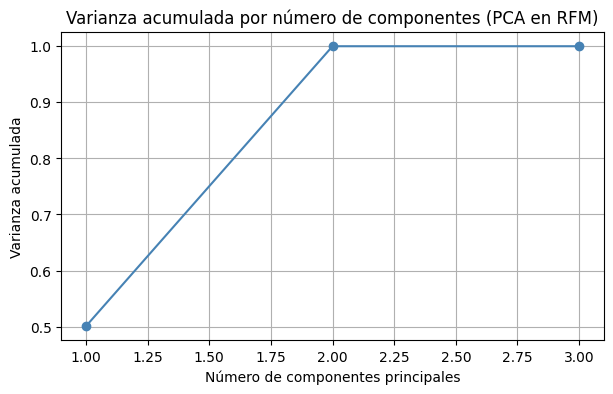

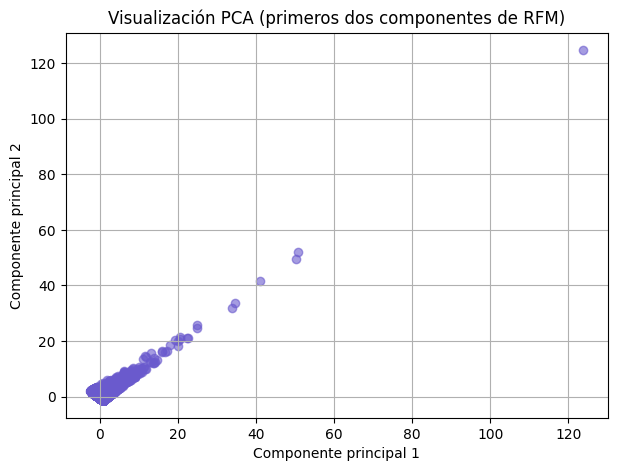

In [102]:
# Usamos las variables RFM escaladas directamente
# X_rfm_scaled_df ya es un DataFrame con las columnas correctas y escaladas

# Aplicamos PCA
# n_components debe ser igual o menor al número de características (3 para RFM)
pca_rfm = PCA(n_components=3)
pca_result_rfm = pca_rfm.fit_transform(X_rfm_scaled_df)

# Varianza explicada
explained_variance_rfm = pca_rfm.explained_variance_ratio_
cumulative_variance_rfm = np.cumsum(explained_variance_rfm)

# Mostramos resultados
print("Resultados PCA para RFM:")
for i, v in enumerate(explained_variance_rfm):
    print(f"Componente {i+1}: {v*100:.2f}% de varianza explicada")
print(f"Varianza total explicada por los 2 primeros componentes: {cumulative_variance_rfm[1]*100:.2f}%")

# Gráfico de varianza acumulada
plt.figure(figsize=(7,4))
plt.plot(range(1, len(cumulative_variance_rfm)+1), cumulative_variance_rfm, marker='o', color='steelblue')
plt.title("Varianza acumulada por número de componentes (PCA en RFM)")
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.show()

# Gráfico de dispersión (2 componentes principales)
plt.figure(figsize=(7,5))
plt.scatter(pca_result_rfm[:, 0], pca_result_rfm[:, 1], alpha=0.6, color='slateblue')
plt.title("Visualización PCA (primeros dos componentes de RFM)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

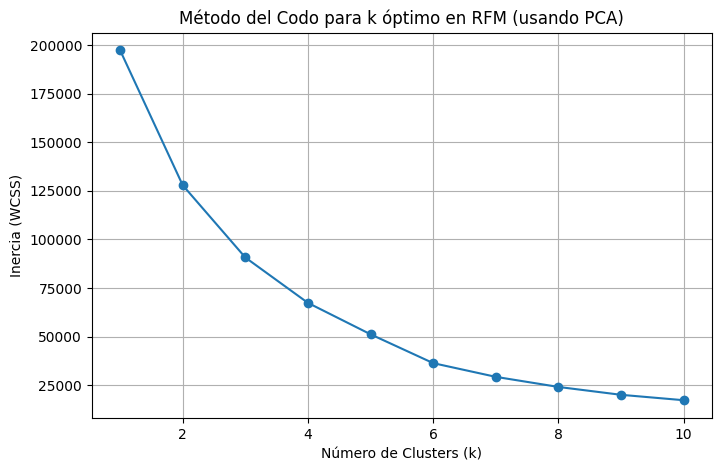

Observa el gráfico para identificar el 'codo' que sugiere el número óptimo de clusters.


In [103]:
# Método del Codo para determinar el número óptimo de clusters (k)
inertia_rfm = []
k_range_rfm = range(1, 11)

for k in k_range_rfm:
    kmeans_rfm = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_rfm.fit(pca_result_rfm)
    inertia_rfm.append(kmeans_rfm.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range_rfm, inertia_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para k óptimo en RFM (usando PCA)')
plt.grid(True)
plt.show()

print("Observa el gráfico para identificar el 'codo' que sugiere el número óptimo de clusters.")

In [ ]:
silhouette_scores_rfm = []
vrc_scores_rfm = []
k_range_metrics = range(2, 11) # Se necesita al menos 2 clusters para estas métricas

for k in k_range_metrics:
    kmeans_rfm = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_rfm = kmeans_rfm.fit_predict(pca_result_rfm)

    # Calcular Silhouette Score
    score_silhouette = silhouette_score(pca_result_rfm, labels_rfm)
    silhouette_scores_rfm.append(score_silhouette)

    # Calcular Calinski-Harabasz Score (VRC)
    score_vrc = calinski_harabasz_score(pca_result_rfm, labels_rfm)
    vrc_scores_rfm.append(score_vrc)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range_metrics, silhouette_scores_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para k óptimo en RFM (usando PCA)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range_metrics, vrc_scores_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('VRC (Calinski-Harabasz Score)')
plt.title('VRC para k óptimo en RFM (usando PCA)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Encontrar el k óptimo basado en Silhouette y VRC
optimal_k_silhouette_rfm = k_range_metrics[np.argmax(silhouette_scores_rfm)]
max_silhouette_score_rfm = np.max(silhouette_scores_rfm)

optimal_k_vrc_rfm = k_range_metrics[np.argmax(vrc_scores_rfm)]
max_vrc_score_rfm = np.max(vrc_scores_rfm)

print(f"El valor máximo del coeficiente de silueta para RFM es {max_silhouette_score_rfm:.2f} en {optimal_k_silhouette_rfm} clusters.")
print(f"El pico del índice VRC para RFM se encuentra en {optimal_k_vrc_rfm} clusters, con un valor de {max_vrc_score_rfm:.2f}.")

## KMeans en RFM con 2 clusters

In [104]:
# Definir el número de clusters
num_clusters_rfm = 2

# Inicializar y ajustar el modelo K-Means
kmeans_rfm_final = KMeans(
    n_clusters=num_clusters_rfm,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans_rfm_final.fit(pca_result_rfm)

# Asignar las etiquetas de cluster a los datos originales de customer_rfm
customer_rfm['RFM_Cluster'] = kmeans_rfm_final.labels_

print(f"K-Means clustering aplicado con {num_clusters_rfm} clusters a los datos RFM (PCA-transformados).")
print("Primeras filas del DataFrame de clientes con etiquetas de cluster:")
display(customer_rfm.head())

K-Means clustering aplicado con 2 clusters a los datos RFM (PCA-transformados).
Primeras filas del DataFrame de clientes con etiquetas de cluster:


,customer_id,RFM_Recency,RFM_Frequency,RFM_Monetary,RFM_Cluster
0,00012a2ce6f8dcda20d059ce98491703,293,1,114.74,0
1,000161a058600d5901f007fab4c27140,414,1,67.41,0
2,0001fd6190edaaf884bcaf3d49edf079,552,1,195.42,0
3,0002414f95344307404f0ace7a26f1d5,383,1,179.35,0
4,000379cdec625522490c315e70c7a9fb,154,1,107.01,1


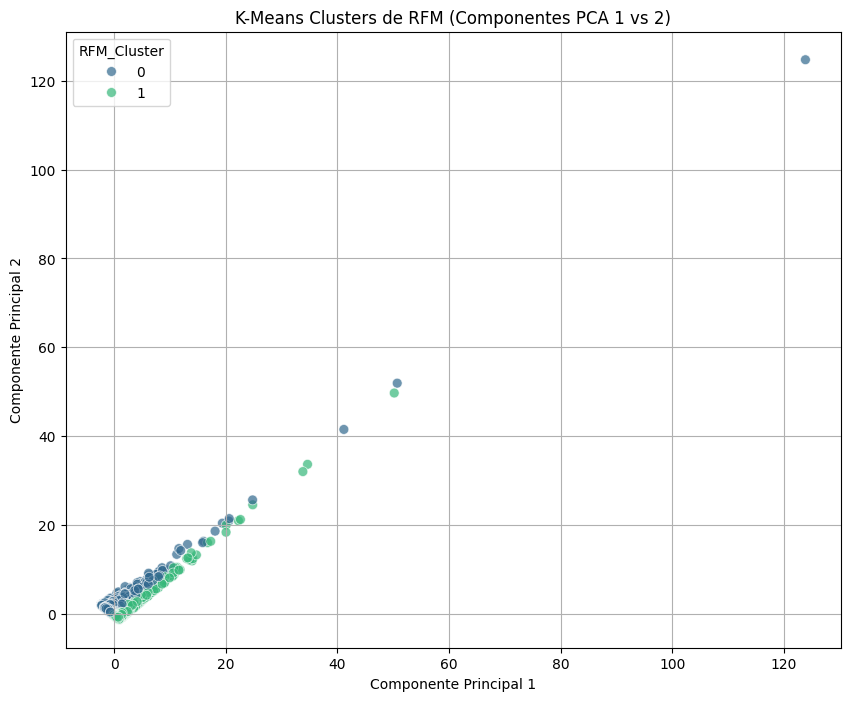

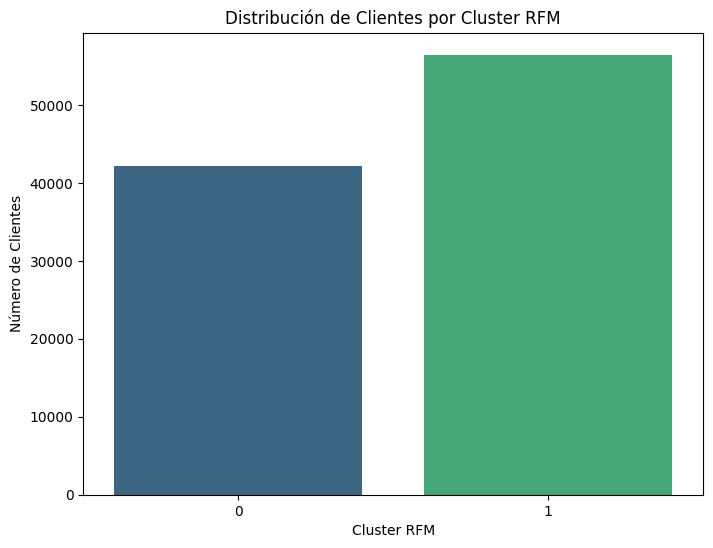

Características promedio de cada cluster RFM:


,RFM_Recency,RFM_Frequency,RFM_Monetary
RFM_Cluster,,,
0,394.613451,1.0,207.939782
1,134.556258,1.0,204.251824


Tamaño de cada cluster RFM:


,count
RFM_Cluster,
0,42212
1,56454


In [105]:
# Visualización de los clusters en los dos primeros componentes principales de PCA de RFM
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result_rfm[:, 0], y=pca_result_rfm[:, 1], hue=customer_rfm['RFM_Cluster'], palette='viridis', legend='full', s=50, alpha=0.7)
plt.title('K-Means Clusters de RFM (Componentes PCA 1 vs 2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

# Visualización de la distribución de clientes por cluster
plt.figure(figsize=(8, 6))
sns.countplot(x='RFM_Cluster', data=customer_rfm, hue='RFM_Cluster', palette='viridis', legend=False)
plt.title('Distribución de Clientes por Cluster RFM')
plt.xlabel('Cluster RFM')
plt.ylabel('Número de Clientes')
plt.show()

# Analizar las características promedio de cada cluster
cluster_means = customer_rfm.groupby('RFM_Cluster')[['RFM_Recency', 'RFM_Frequency', 'RFM_Monetary']].mean()
print("Características promedio de cada cluster RFM:")
display(cluster_means)

cluster_sizes = customer_rfm['RFM_Cluster'].value_counts().sort_index()
print("Tamaño de cada cluster RFM:")
display(cluster_sizes)

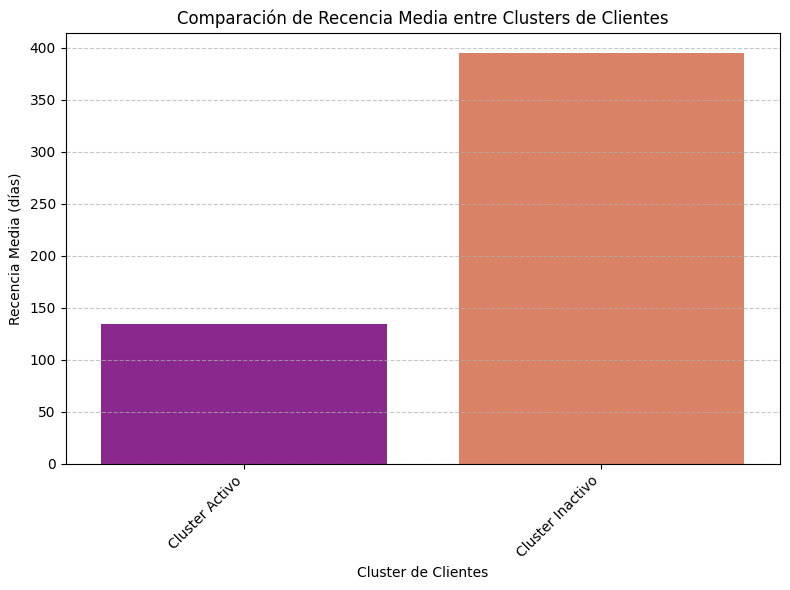

In [106]:
# Calcular la recencia media por cluster
recency_by_cluster = customer_rfm.groupby('RFM_Cluster')['RFM_Recency'].mean().reset_index()

# Identificar el cluster con menor recencia (más activo) y el con mayor recencia (más inactivo)
# Asumiendo que 0 es el cluster con menor recencia y 1 con mayor, según la interpretación previa de cluster_means
# Si esto no es consistente, se puede reasignar basado en los valores reales.
recency_by_cluster = recency_by_cluster.sort_values(by='RFM_Recency', ascending=True)
recency_by_cluster['Etiqueta_Cluster'] = ['Cluster Activo' if i == 0 else 'Cluster Inactivo' for i in range(len(recency_by_cluster))]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Etiqueta_Cluster', y='RFM_Recency', data=recency_by_cluster, palette='plasma')
plt.title('Comparación de Recencia Media entre Clusters de Clientes')
plt.xlabel('Cluster de Clientes')
plt.ylabel('Recencia Media (días)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Con 2 clusters, la principal distinción clara entre los segmentos es la Recencia. Los valores monetarios son muy similares entre ambos clusters, lo que sugiere que el gasto promedio de los clientes es consistente independientemente de cuándo compraron.

La Frecuencia sigue siendo 1.0 en ambos clusters, confirmando la naturaleza de cliente de "una sola compra" predominante en el dataset, como ya habíamos notado. Esto significa que la segmentación se basa casi exclusivamente en la recencia del cliente.

Esta segmentación de 2 clusters nos permite identificar claramente entre clientes que compraron hace más tiempo y aquellos que lo hicieron más recientemente, lo cual es útil para campañas de marketing dirigidas a la reactivación o la fidelización temprana, respectivamente.

# Tests de hipótesis

## Hipótesis de comparación de medias de recencia en clusters

In [ ]:
vars_to_test = ["RFM_Recency", "RFM_Frequency", "RFM_Monetary"]
cluster_col = "RFM_Cluster"
c0, c1 = 0, 1   # los dos clusters a comparar

def cohens_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    if nx < 2 or ny < 2: return np.nan
    sp2 = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
    return (np.mean(x) - np.mean(y)) / np.sqrt(sp2) if sp2 > 0 else np.nan

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0: return np.nan
    # más eficiente que doble bucle para muestras grandes: usar ranking
    ranks = stats.rankdata(np.concatenate([x, y]))
    rx = ranks[:nx].sum()
    # delta = (2*rx - nx*(nx+1)) / (nx*ny) - 1  -> corrección:
    delta = (2*rx - nx*(nx+1)) / (nx*ny) - 1
    return delta

print("Tamaño de cada cluster:")
print(customer_rfm.groupby(cluster_col).size())

results = []
for v in vars_to_test:
    print("\n" + "="*70)
    print(f"Variable: {v}")

    x = customer_rfm.loc[customer_rfm[cluster_col] == c0, v].dropna()
    y = customer_rfm.loc[customer_rfm[cluster_col] == c1, v].dropna()

    # Chequeo: si la varianza es 0 en alguno → no se puede comparar con t ni MWU
    if x.nunique() <= 1 or y.nunique() <= 1:
        print("⚠️ Alguno de los grupos es constante → no se puede testear diferencia (varianza=0).")
        print(f"Medias: C{c0}={x.mean():.4f}, C{c1}={y.mean():.4f}")
        results.append([v, "Constante", np.nan, np.nan, np.nan, np.nan, np.nan])
        continue

    # 1) Normalidad (como en tu ejemplo: normaltest)
    p_norm_x = stats.normaltest(x).pvalue if len(x) >= 8 else np.nan
    p_norm_y = stats.normaltest(y).pvalue if len(y) >= 8 else np.nan
    print(f"Normalidad (D’Agostino–Pearson): p_C{c0}={p_norm_x:.3g}, p_C{c1}={p_norm_y:.3g}")

    # 2) Homogeneidad de varianzas (Levene) – solo informativo
    p_levene = stats.levene(x, y, center='median').pvalue
    print(f"Levene (varianzas iguales): p={p_levene:.3g}")

    # 3) Elegir test
    normal_ok = (p_norm_x is not np.nan and p_norm_x >= 0.05) and (p_norm_y is not np.nan and p_norm_y >= 0.05)

    if normal_ok:
        # t-test Welch por defecto (robusto si varianzas difieren)
        tstat, p_t = stats.ttest_ind(x, y, equal_var=False)
        d = cohens_d(x, y)
        print(f"t de Student (Welch): t={tstat:.3f}, p={p_t:.3g}, Cohen's d={d:.3f}")
        test_used = "t-Welch"
        stat, pval, eff, eff_name = tstat, p_t, d, "Cohen's d"
    else:
        # No normalidad → Mann–Whitney U
        u, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
        delta = cliffs_delta(x, y)
        print(f"Mann–Whitney U: U={u:.0f}, p={p_u:.3g}, Cliff's δ={delta:.3f}")
        test_used = "Mann–Whitney"
        stat, pval, eff, eff_name = u, p_u, delta, "Cliff's δ"

    # 4) Resumen
    print(f"Medias: C{c0}={x.mean():.3f}, C{c1}={y.mean():.3f} | Medianas: C{c0}={x.median():.3f}, C{c1}={y.median():.3f}")
    results.append([v, test_used, stat, pval, eff_name, eff, p_levene])

cols = ["Variable", "Test", "Estadístico", "p-valor", "Efecto", "Magnitud", "p-Levene"]
res_df = pd.DataFrame(results, columns=cols).sort_values("p-valor")
print("\nResumen comparaciones 0 vs 1:")
print(res_df.to_string(index=False))

## Hipótesis 4

In [ ]:
df = fact_order_items.copy()

cols_needed = ['freight_percentage', 'order_delivered_customer_date', 'review_score']
df = df[cols_needed].copy()

df['is_canceled'] = df['order_delivered_customer_date'].isna().astype(int)

df = df.dropna(subset=['freight_percentage'])

# =======================
# A) CANCELACIÓN vs % FLETE
# =======================

x = df.loc[df['is_canceled'] == 1, 'freight_percentage']   # cancelados
y = df.loc[df['is_canceled'] == 0, 'freight_percentage']   # no cancelados

print(f"[A] N cancelados={len(x)}, N no cancelados={len(y)}")

# Normalidad por grupo (informativo)
p_norm_x = stats.normaltest(x).pvalue if len(x) >= 8 else np.nan
p_norm_y = stats.normaltest(y).pvalue if len(y) >= 8 else np.nan
print(f"Normalidad D’Agostino–Pearson: p(cancelados)={p_norm_x:.3g}, p(no cancelados)={p_norm_y:.3g}")

# Homogeneidad de varianzas (Levene, informativo)
p_levene = stats.levene(x, y, center='median').pvalue if (len(x) > 1 and len(y) > 1) else np.nan
print(f"Levene (varianzas iguales): p={p_levene:.3g}")

normal_ok = (not np.isnan(p_norm_x) and p_norm_x >= 0.05) and \
            (not np.isnan(p_norm_y) and p_norm_y >= 0.05)

if normal_ok:
    # t de Student con corrección de Welch
    tstat, p_t = stats.ttest_ind(x, y, equal_var=False)
    print(f"t de Student (Welch): t={tstat:.3f}, p={p_t:.3g}")
else:
    # Mann–Whitney U (no paramétrico)
    u, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
    print(f"Mann–Whitney U: U={u:.0f}, p={p_u:.3g}")
    # Comparación completa de distribuciones (opcional, visto en clase)
    ks = stats.ks_2samp(x, y)
    print(f"Kolmogorov–Smirnov 2-muestras: D={ks.statistic:.3f}, p={ks.pvalue:.3g}")

print(f"Medianas %flete:  Cancelados={x.median():.4f} | No cancelados={y.median():.4f}")
print(f"Medias %flete:    Cancelados={x.mean():.4f}   | No cancelados={y.mean():.4f}")

# --- Alternativa categórica: terciles de % flete + Chi-cuadrado con cancelación ---
df['freight_tercile'] = pd.qcut(df['freight_percentage'], q=3, labels=['Bajo','Medio','Alto'])
ct = pd.crosstab(df['freight_tercile'], df['is_canceled'])  # filas: tercil; columnas: 0/1
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)
print("\nChi-cuadrado (terciles % flete x cancelación):")
print(ct)
print(f"χ²={chi2:.3f}, gl={dof}, p={p_chi:.3g}")

# =======================
# B) SATISFACCIÓN (review_score) vs % FLETE
# =======================

df_b = df.dropna(subset=['review_score']).copy()

# Spearman (monotónica)
rho, p_s = stats.spearmanr(df_b['freight_percentage'], df_b['review_score'])
print(f"\nSpearman entre %flete y review_score: ρ={rho:.3f}, p={p_s:.3g}")
# Esperado: ρ negativo (más %flete -> menor rating)

# Comparar review_score entre terciles de % flete
g_bajo  = df_b.loc[df_b['freight_tercile'] == 'Bajo',  'review_score']
g_medio = df_b.loc[df_b['freight_tercile'] == 'Medio', 'review_score']
g_alto  = df_b.loc[df_b['freight_tercile'] == 'Alto',  'review_score']

# Normalidad por grupo (informativo)
pn_b = stats.normaltest(g_bajo).pvalue  if len(g_bajo)  >= 8 else np.nan
pn_m = stats.normaltest(g_medio).pvalue if len(g_medio) >= 8 else np.nan
pn_a = stats.normaltest(g_alto).pvalue  if len(g_alto)  >= 8 else np.nan
print(f"Normalidad review_score por tercil: p(Bajo)={pn_b:.3g}, p(Medio)={pn_m:.3g}, p(Alto)={pn_a:.3g}")

# Si TODAS normales -> ANOVA; si no -> Kruskal–Wallis
all_normal = all([not np.isnan(p) and p >= 0.05 for p in [pn_b, pn_m, pn_a]])

if all_normal:
    fstat, p_anova = stats.f_oneway(g_bajo, g_medio, g_alto)
    print(f"ANOVA review_score ~ terciles %flete: F={fstat:.3f}, p={p_anova:.3g}")
else:
    hstat, p_kw = stats.kruskal(g_bajo, g_medio, g_alto)
    print(f"Kruskal–Wallis review_score ~ terciles %flete: H={hstat:.3f}, p={p_kw:.3g}")

print(f"Medianas review_score por tercil %flete: Bajo={g_bajo.median():.3f} | Medio={g_medio.median():.3f} | Alto={g_alto.median():.3f}")
print(f"Medias review_score por tercil %flete:    Bajo={g_bajo.mean():.3f}   | Medio={g_medio.mean():.3f}   | Alto={g_alto.mean():.3f}")

# Exportación de CSV para Power BI

In [ ]:
# Definir patrones de exclusión para las columnas de preprocesamiento
exclusion_patterns = [
    'z_score_', 'boxcox_', 'yeojohnson_', 'cleaned_', 'boxcox_imputed_',
    '_orig', 'review_score_str'
]

# Filtrar las columnas que no coincidan con los patrones de exclusión
columns_to_export = []
for col in fact_order_items.columns:
    if not any(pattern in col for pattern in exclusion_patterns):
        columns_to_export.append(col)

# Crear un nuevo DataFrame con solo las columnas deseadas
fact_order_items_filtered = fact_order_items[columns_to_export].copy()

# Exportar el DataFrame filtrado a CSV
csv_path_filtered = '/content/fact_order_items_cleaned.csv'
fact_order_items_filtered.to_csv(csv_path_filtered, index=False)

print(f"El DataFrame 'fact_order_items_cleaned' (filtrado) ha sido exportado a: {csv_path_filtered}")
print("Columnas exportadas:", fact_order_items_filtered.columns.tolist())

# Para verificar el contenido del archivo CSV exportado (opcional)
print("Primeras 5 filas del archivo CSV exportado:")
with open(csv_path_filtered, 'r') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line.strip())

In [ ]:
df = pd.read_csv('/content/fact_order_items_cleaned.csv')
df.info()